# Import libraries

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)

import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet

from sktime.forecasting.arima import ARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

In [2]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), ".."))
from src.toolbox.data import Data
from src.toolbox.data_model import DataModel
from src.toolbox.model import Model

In [3]:
def cv_summary(data_model: DataModel, model: Model, test_size: int=12) -> pd.DataFrame:
    """Performs cross-validation, computes forecast metrics, and returns a summary DataFrame.

    Parameters
    ----------
    data_model : DataModel
        An instance of the DataModel class containing the time series data.
    model : Model
        An instance of the Model class to be used for forecasting.
    test_size : int, optional
        The size of the test set for cross-validation, by default 12.

    Returns
    -------
    pd.DataFrame
        A DataFrame containing the cross-validation summary with model name, cross-validation split, 
        and computed metrics (MAPE, MAE, and RMSE).
    """
    ttt = data_model.ttt_split(test_size=test_size)
    cvs = []
    for cv, data in ttt.items():
        train, test = data
        fcast = model.forecast(data=train)
        metrics = data_model.get_metrics(forecast=fcast, true=test)
        summary = {
            "name": str(model.model),
            "cv": cv,
            **metrics
        }
        cvs.append(summary)
    return pd.DataFrame(cvs)


def plot(data_model: DataModel, model: Model, cv: str, test_size: int=12, **kwargs) -> None:
    """
    Plots the past, future, and forecasted time series data for a given cross-validation split.

    Parameters
    ----------
    data_model : DataModel
        An instance of the DataModel class containing the time series data.
    model : Model
        An instance of the Model class to be used for forecasting.
    cv : str
        The cross-validation split identifier (e.g., 'cv1', 'cv2').
    test_size : int, optional
        The size of the test set for cross-validation, by default 12.
    **kwargs : dict
        Additional keyword arguments to customize the plot, such as the title.

    Returns
    -------
    None
    """
    ttt = data_model.ttt_split(test_size=test_size)
    past = ttt[cv][0]
    future = ttt[cv][-1]
    forecast = model.forecast(past)
    if "title" in kwargs.keys():
        title = f"{kwargs.get('title')} - {cv}"
    else:
        title = f"TS Forecasted - {cv}"
    data_model.plot_ts(past=past, future=future, forecasted=forecast, title=title)

# Read needed data and set varibles

In [4]:
n_trials = 100

data = Data(path="../train.csv").read()
data_model = DataModel(dataframe=data)

# ARIMA

From the eda.ipynb we detect that p=1, d=0, q=1 and p=12, d=0, q=1 are two possible models for AR and MA. Let"s check with other models to see if it is better.

Just to keep in mind:
- cv2 (cross-validation 2): Is a model trained with all data except latest 12 months, and the validation test are those 12 months.
- cv1 (cross-validation 1): Is a model trained with all data except latest 24 months, and the test set are the following 12 months from that date.


In [5]:
arima_orders = [(12, 0, 1), (1, 0, 1), (6, 0, 1), (1, 0, 3)]
dfs = []
for order in arima_orders:
    model = Model(model=ARIMA, order=order)
    dfs.append(cv_summary(data_model=data_model, model=model))

arima_summary = pd.concat(dfs)

c:\Users\EstebanSanchezGarcia\Documents\Personal\Mercedes\ads\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\EstebanSanchezGarcia\Documents\Personal\Mercedes\ads\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\EstebanSanchezGarcia\Documents\Personal\Mercedes\ads\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [6]:
arima_summary

name   cv      mape       mae      rmse
0  ARIMA(order=(12, 0, 1))  cv1  0.169478  0.475080  0.594142
1  ARIMA(order=(12, 0, 1))  cv2  0.316211  0.666748  0.843188
0   ARIMA(order=(1, 0, 1))  cv1  0.203860  0.590317  0.728484
1   ARIMA(order=(1, 0, 1))  cv2  0.239276  0.513922  0.595615
0   ARIMA(order=(6, 0, 1))  cv1  0.163168  0.476843  0.633322
1   ARIMA(order=(6, 0, 1))  cv2  0.267542  0.584259  0.700019
0   ARIMA(order=(1, 0, 3))  cv1  0.196153  0.560536  0.682623
1   ARIMA(order=(1, 0, 3))  cv2  0.254841  0.538508  0.659542

c:\Users\EstebanSanchezGarcia\Documents\Personal\Mercedes\ads\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


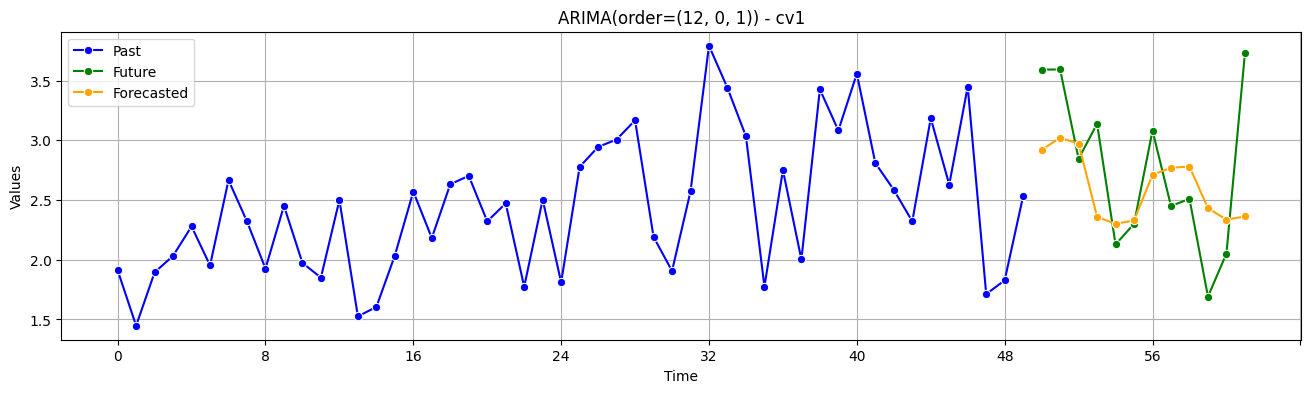

In [7]:
model = Model(model=ARIMA, order=(12, 0, 1))
plot(data_model=data_model, model=model, cv="cv1", title=str(model.model))

c:\Users\EstebanSanchezGarcia\Documents\Personal\Mercedes\ads\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


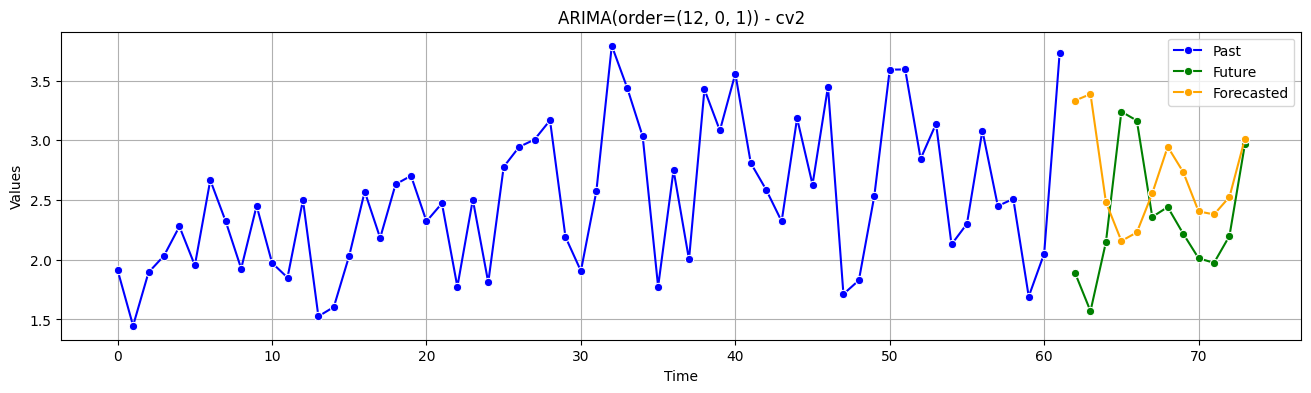

In [8]:
model = Model(model=ARIMA, order=(12, 0, 1))
plot(data_model=data_model, model=model, cv="cv2", title=str(model.model))

As we spected from our analysis, combining the results with the plot, ARIMA(12, 0, 1) is one of the best model. We have to deal with larger errors over CV2 because of the inconsistency of the TS. That is why we are going to apply hyper parameter tunning and then analyse the results in terms of best mean RMSE over CV1 and CV2 and over the best performance on CV2 (which is the validation set).

## Hyperparameter Tunning

In [9]:
ttt = data_model.ttt_split()

def arima_optimizer(trial) -> float:
    """
    Optimizes ARIMA model hyperparameters using cross-validation and returns the RMSE.

    Parameters
    ----------
    trial : optuna.trial.Trial
        An Optuna trial object used for suggesting hyperparameters.

    Returns
    -------
    float
        The RMSE of the forecast on the validation set.

    Notes
    -----
    This function is designed to be used with Optuna for hyperparameter optimization.
    It tunes the p, d, and q parameters of the ARIMA model.
    """
    # Hyperparameters to tune
    p = trial.suggest_int("p", 1, 12)
    d = trial.suggest_int("d", 0, 2)
    q = trial.suggest_int("q", 1, 12)

    # Model setup
    model = Model(model=ARIMA, order=(p, d, q))
    cv1 = ttt["cv1"]
    fcast = model.forecast(cv1[0])

    # Metrics
    summary = data_model.get_metrics(forecast=fcast, true=cv1[-1])

    return summary["rmse"]

study = optuna.create_study(direction="minimize")
study.optimize(arima_optimizer, n_trials=n_trials, n_jobs=-1)

c:\Users\EstebanSanchezGarcia\Documents\Personal\Mercedes\ads\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\EstebanSanchezGarcia\Documents\Personal\Mercedes\ads\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\EstebanSanchezGarcia\Documents\Personal\Mercedes\ads\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\EstebanSanchezGarcia\Documents\Personal\Mercedes\ads\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check m

In [10]:
top5_trials = sorted(study.get_trials(), key=lambda ele: ele.values[0])[:5]
dfs = []
for idx, trial in enumerate(top5_trials, start=1):
    params = trial.params
    order = (params.get("p"), params.get("d"), params.get("q"))
    model = Model(model=ARIMA, order=order)
    summary = cv_summary(data_model=data_model, model=model)
    summary["top_trial"] = idx
    summary["params"] = [params] * 2
    dfs.append(summary)

arima_hpt_summary = pd.concat(dfs)

c:\Users\EstebanSanchezGarcia\Documents\Personal\Mercedes\ads\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\EstebanSanchezGarcia\Documents\Personal\Mercedes\ads\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\EstebanSanchezGarcia\Documents\Personal\Mercedes\ads\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\EstebanSanchezGarcia\Documents\Personal\Mercedes\ads\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check m

In [11]:
arima_hpt_summary

name   cv      mape       mae      rmse  top_trial  \
0  ARIMA(order=(12, 0, 5))  cv1  0.151748  0.426975  0.541291          1   
1  ARIMA(order=(12, 0, 5))  cv2  0.309006  0.660370  0.858145          1   
0   ARIMA(order=(5, 0, 2))  cv1  0.186109  0.485892  0.564199          2   
1   ARIMA(order=(5, 0, 2))  cv2  0.277962  0.598460  0.710909          2   
0   ARIMA(order=(5, 0, 2))  cv1  0.186109  0.485892  0.564199          3   
1   ARIMA(order=(5, 0, 2))  cv2  0.277962  0.598460  0.710909          3   
0   ARIMA(order=(5, 0, 2))  cv1  0.186109  0.485892  0.564199          4   
1   ARIMA(order=(5, 0, 2))  cv2  0.277962  0.598460  0.710909          4   
0   ARIMA(order=(5, 0, 2))  cv1  0.186109  0.485892  0.564199          5   
1   ARIMA(order=(5, 0, 2))  cv2  0.277962  0.598460  0.710909          5   

                      params  
0  {'p': 12, 'd': 0, 'q': 5}  
1  {'p': 12, 'd': 0, 'q': 5}  
0   {'p': 5, 'd': 0, 'q': 2}  
1   {'p': 5, 'd': 0, 'q': 2}  
0   {'p': 5, 'd': 0, 'q': 2}  
1   {'p': 5, 'd': 0, 'q': 2}  
0   {'p': 5, 'd': 0, 'q': 2}  
1   {'p': 5, 'd': 0, 'q': 2}  
0   {'p': 5, 'd': 0, 'q': 2}  
1   {'p': 5, 'd': 0, 'q': 2}

### Best performance on CV2

In [12]:
best_perf = arima_hpt_summary[arima_hpt_summary["cv"] == "cv2"].sort_values("rmse")
best_perf

name   cv      mape      mae      rmse  top_trial  \
1   ARIMA(order=(5, 0, 2))  cv2  0.277962  0.59846  0.710909          2   
1   ARIMA(order=(5, 0, 2))  cv2  0.277962  0.59846  0.710909          3   
1   ARIMA(order=(5, 0, 2))  cv2  0.277962  0.59846  0.710909          4   
1   ARIMA(order=(5, 0, 2))  cv2  0.277962  0.59846  0.710909          5   
1  ARIMA(order=(12, 0, 5))  cv2  0.309006  0.66037  0.858145          1   

                      params  
1   {'p': 5, 'd': 0, 'q': 2}  
1   {'p': 5, 'd': 0, 'q': 2}  
1   {'p': 5, 'd': 0, 'q': 2}  
1   {'p': 5, 'd': 0, 'q': 2}  
1  {'p': 12, 'd': 0, 'q': 5}

c:\Users\EstebanSanchezGarcia\Documents\Personal\Mercedes\ads\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


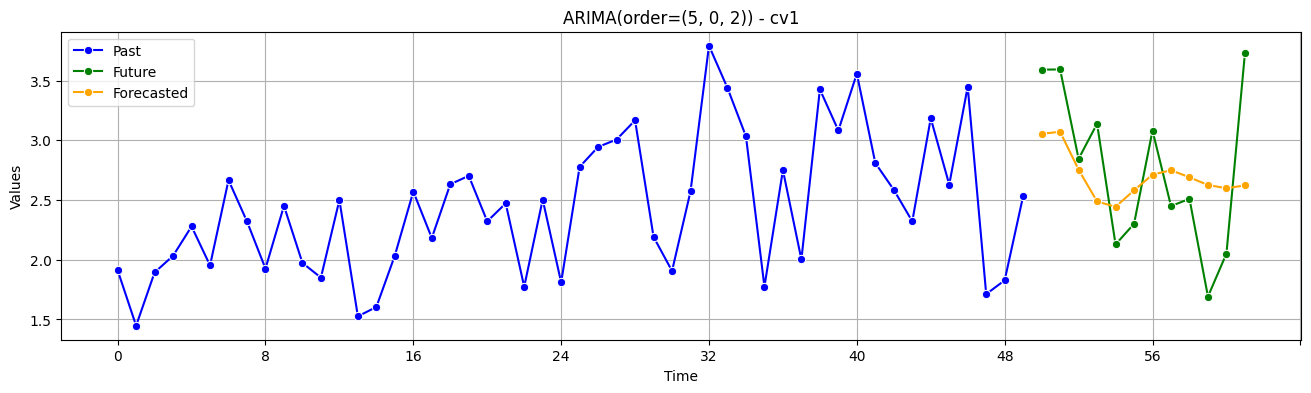

c:\Users\EstebanSanchezGarcia\Documents\Personal\Mercedes\ads\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


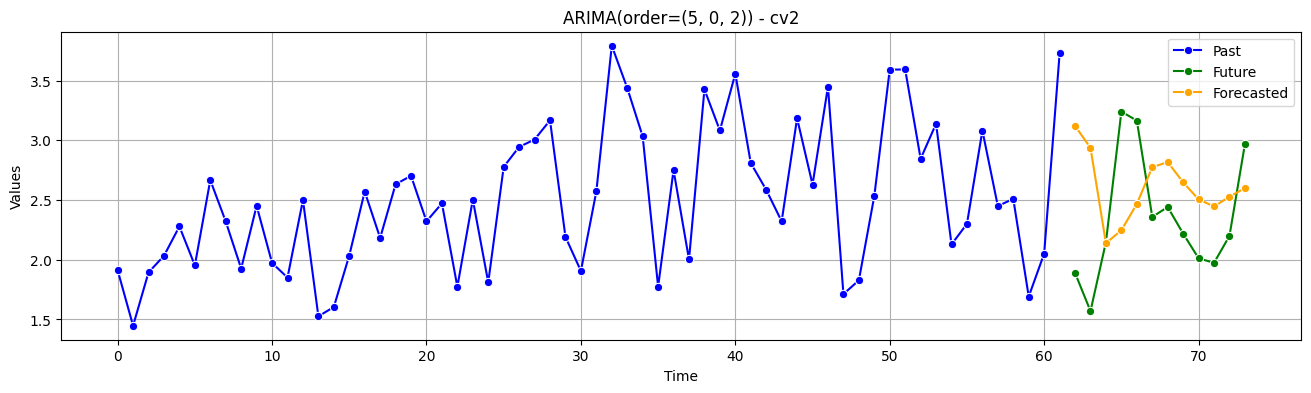

c:\Users\EstebanSanchezGarcia\Documents\Personal\Mercedes\ads\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


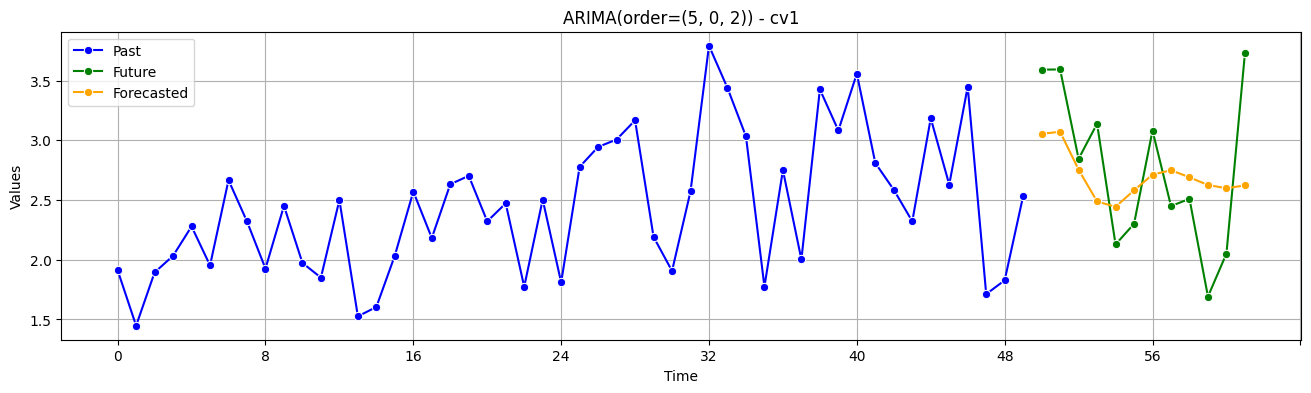

c:\Users\EstebanSanchezGarcia\Documents\Personal\Mercedes\ads\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


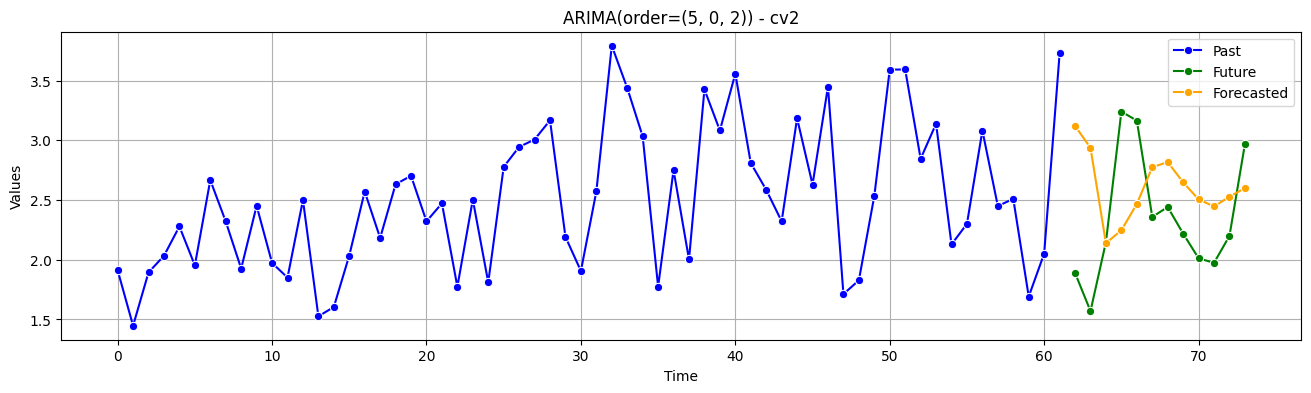

c:\Users\EstebanSanchezGarcia\Documents\Personal\Mercedes\ads\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


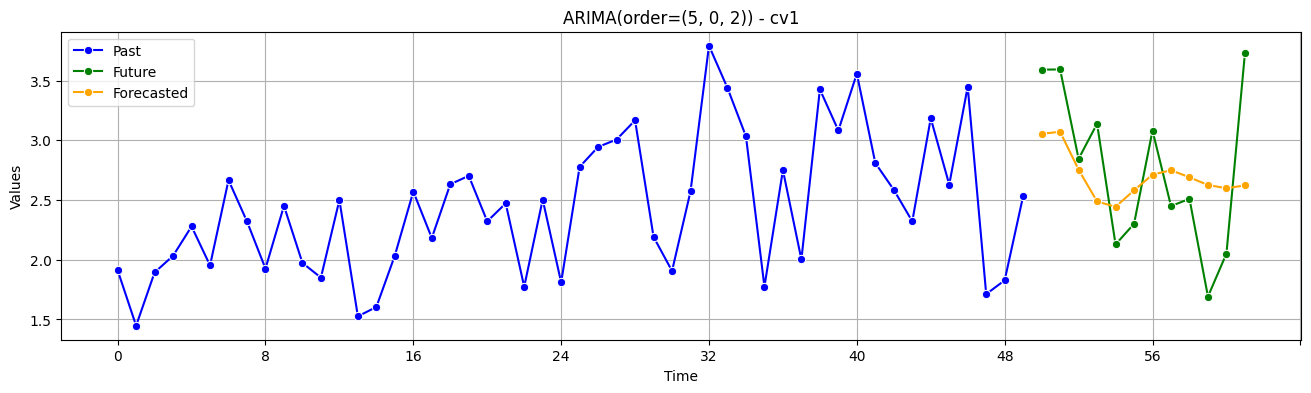

c:\Users\EstebanSanchezGarcia\Documents\Personal\Mercedes\ads\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


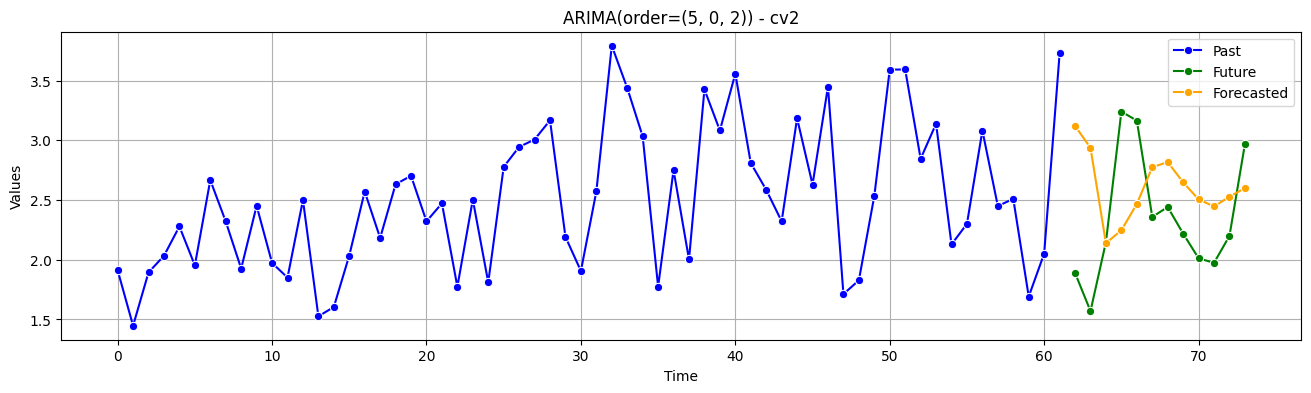

In [13]:
for iteration in best_perf.head(3).itertuples():
    params = iteration.params
    model = Model(model=ARIMA, order=(params["p"], params["d"], params["q"]))
    for cv in ["cv1", "cv2"]:
        plot(data_model=data_model, model=model, cv=cv, title=str(model.model))

### Best stable performance

In [14]:
arima_hpt_summary["params"] = arima_hpt_summary["params"].astype(str)
best_stable = arima_hpt_summary.groupby(["name", "top_trial", "params"], as_index=False)[["mape", "mae", "rmse"]].mean().sort_values("rmse")
best_stable["params"] = best_stable["params"].apply(eval)
best_stable

name  top_trial                     params      mape  \
1   ARIMA(order=(5, 0, 2))          2   {'p': 5, 'd': 0, 'q': 2}  0.232036   
2   ARIMA(order=(5, 0, 2))          3   {'p': 5, 'd': 0, 'q': 2}  0.232036   
3   ARIMA(order=(5, 0, 2))          4   {'p': 5, 'd': 0, 'q': 2}  0.232036   
4   ARIMA(order=(5, 0, 2))          5   {'p': 5, 'd': 0, 'q': 2}  0.232036   
0  ARIMA(order=(12, 0, 5))          1  {'p': 12, 'd': 0, 'q': 5}  0.230377   

        mae      rmse  
1  0.542176  0.637554  
2  0.542176  0.637554  
3  0.542176  0.637554  
4  0.542176  0.637554  
0  0.543672  0.699718

c:\Users\EstebanSanchezGarcia\Documents\Personal\Mercedes\ads\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


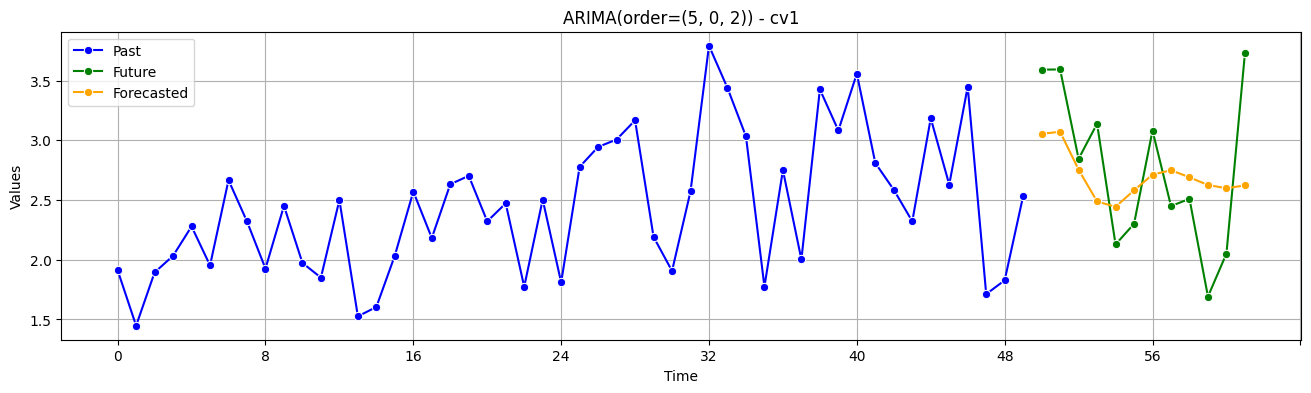

c:\Users\EstebanSanchezGarcia\Documents\Personal\Mercedes\ads\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


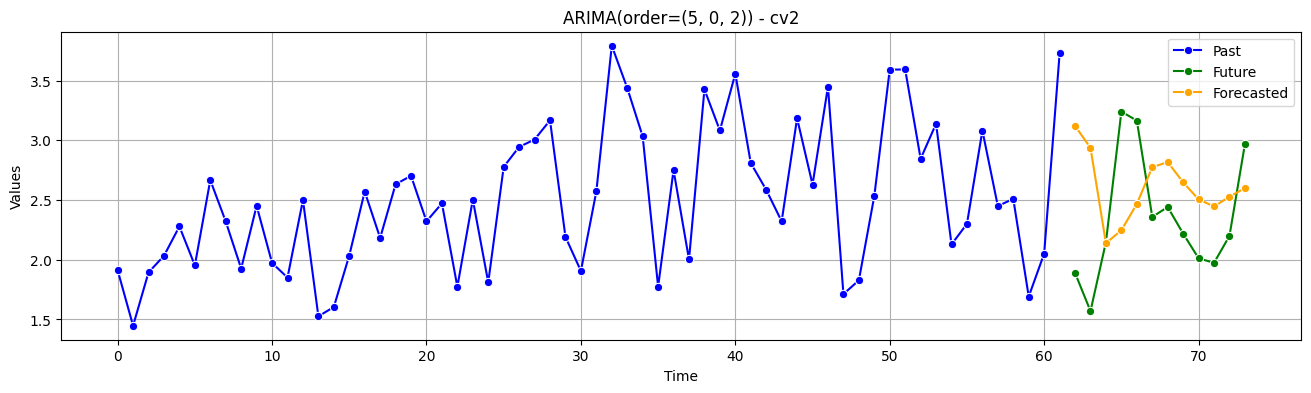

c:\Users\EstebanSanchezGarcia\Documents\Personal\Mercedes\ads\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


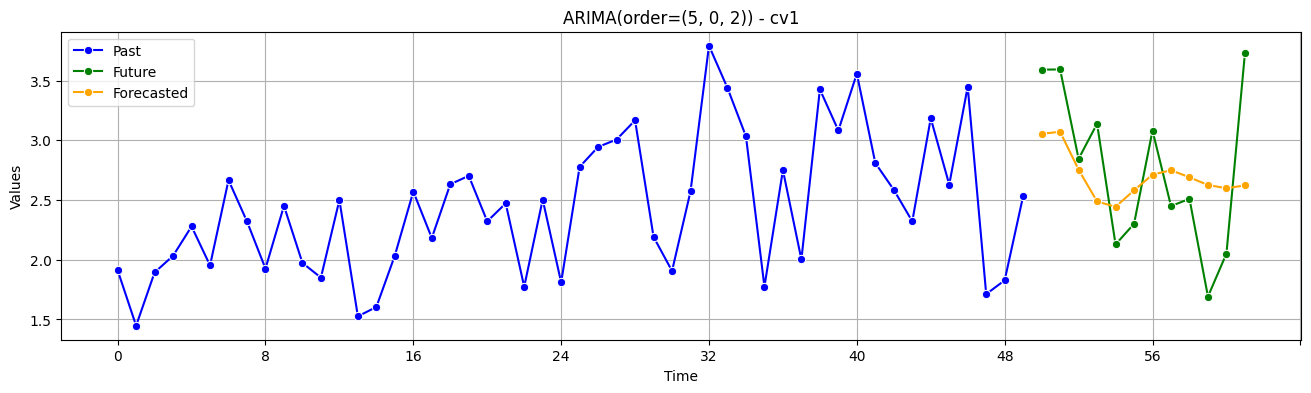

c:\Users\EstebanSanchezGarcia\Documents\Personal\Mercedes\ads\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


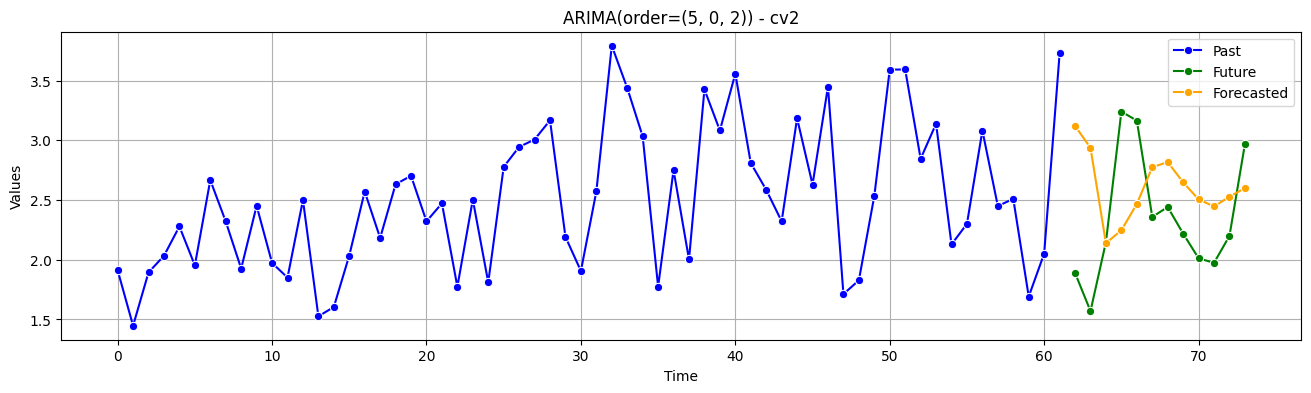

c:\Users\EstebanSanchezGarcia\Documents\Personal\Mercedes\ads\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


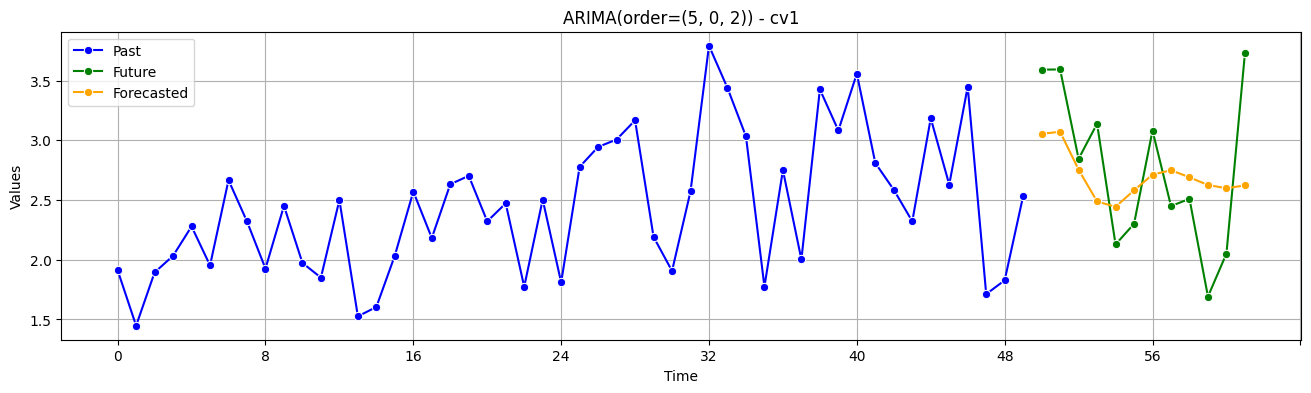

c:\Users\EstebanSanchezGarcia\Documents\Personal\Mercedes\ads\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


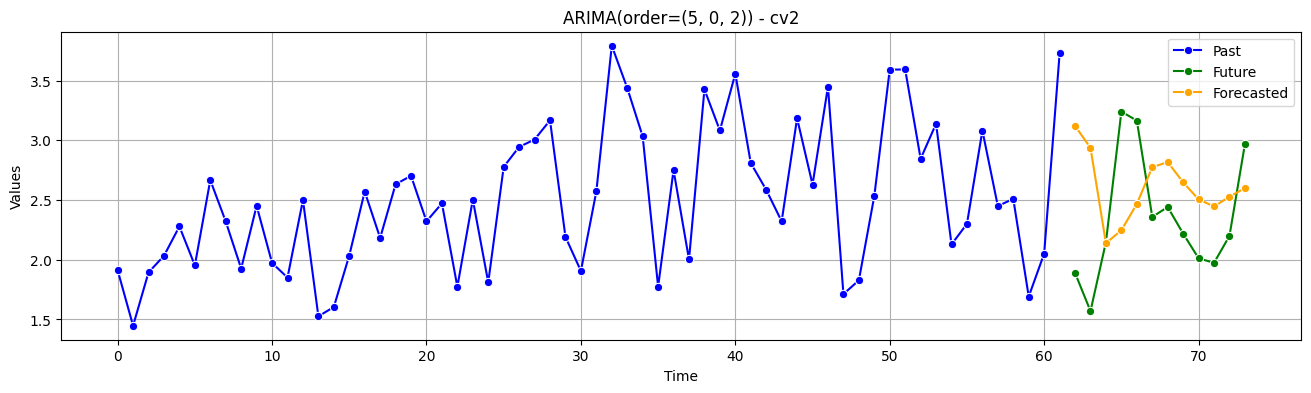

In [15]:
for iteration in best_perf.head(3).itertuples():
    params = iteration.params
    model = Model(model=ARIMA, order=(params["p"], params["d"], params["q"]))
    for cv in ["cv1", "cv2"]:
        plot(data_model=data_model, model=model, cv=cv, title=str(model.model))

ARIMA(5, 1, 2) is the stablest and best tested ARIMA model.

# Exponential Smoothing

In [16]:
ttt = data_model.ttt_split()

def hw_optimizer(trial) -> float:
    """
    Optimizes Exponential Smoothing (Holt-Winters) model hyperparameters using cross-validation and returns the RMSE.

    Parameters
    ----------
    trial : optuna.trial.Trial
        An Optuna trial object used for suggesting hyperparameters.

    Returns
    -------
    float
        The RMSE of the forecast on the validation set.

    Notes
    -----
    This function is designed to be used with Optuna for hyperparameter optimization.
    It tunes the trend, seasonal, and seasonal period (sp) parameters of the Exponential Smoothing model.
    """
    # Hyperparameters to tune
    trend = trial.suggest_categorical("trend", ["mul", "add", None])
    seasonal = trial.suggest_categorical("seasonal", ["add", "mul", None])
    sp = trial.suggest_int("sp", 5, 13)

    # Model setup
    model = Model(model=ExponentialSmoothing, trend=trend, seasonal=seasonal, sp=sp)
    cv1 = ttt["cv1"]
    fcast = model.forecast(cv1[0])

    # Metrics
    summary = data_model.get_metrics(forecast=fcast, true=cv1[-1])

    return summary["rmse"]

study = optuna.create_study(direction="minimize")
study.optimize(hw_optimizer, n_trials=n_trials, n_jobs=-1)

c:\Users\EstebanSanchezGarcia\Documents\Personal\Mercedes\ads\.venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [17]:
top5_trials = sorted(study.get_trials(), key=lambda ele: ele.values[0])[:5]
dfs = []
for idx, trial in enumerate(top5_trials, start=1):
    params = trial.params
    model = Model(model=ExponentialSmoothing, **params)
    summary = cv_summary(data_model=data_model, model=model)
    summary["top_trial"] = idx
    summary["params"] = [params] * 2
    dfs.append(summary)

hw_hpt_summary = pd.concat(dfs)

In [18]:
hw_hpt_summary

name   cv      mape       mae  \
0  ExponentialSmoothing(seasonal='mul', sp=11)  cv1  0.200347  0.524412   
1  ExponentialSmoothing(seasonal='mul', sp=11)  cv2  0.255320  0.540364   
0  ExponentialSmoothing(seasonal='mul', sp=11)  cv1  0.200347  0.524412   
1  ExponentialSmoothing(seasonal='mul', sp=11)  cv2  0.255320  0.540364   
0  ExponentialSmoothing(seasonal='mul', sp=11)  cv1  0.200347  0.524412   
1  ExponentialSmoothing(seasonal='mul', sp=11)  cv2  0.255320  0.540364   
0  ExponentialSmoothing(seasonal='add', sp=11)  cv1  0.201908  0.529202   
1  ExponentialSmoothing(seasonal='add', sp=11)  cv2  0.258807  0.544695   
0  ExponentialSmoothing(seasonal='add', sp=11)  cv1  0.201908  0.529202   
1  ExponentialSmoothing(seasonal='add', sp=11)  cv2  0.258807  0.544695   

       rmse  top_trial                                        params  
0  0.558111          1  {'trend': None, 'seasonal': 'mul', 'sp': 11}  
1  0.656137          1  {'trend': None, 'seasonal': 'mul', 'sp': 11}  
0  0.558111          2  {'trend': None, 'seasonal': 'mul', 'sp': 11}  
1  0.656137          2  {'trend': None, 'seasonal': 'mul', 'sp': 11}  
0  0.558111          3  {'trend': None, 'seasonal': 'mul', 'sp': 11}  
1  0.656137          3  {'trend': None, 'seasonal': 'mul', 'sp': 11}  
0  0.571042          4  {'trend': None, 'seasonal': 'add', 'sp': 11}  
1  0.647886          4  {'trend': None, 'seasonal': 'add', 'sp': 11}  
0  0.571042          5  {'trend': None, 'seasonal': 'add', 'sp': 11}  
1  0.647886          5  {'trend': None, 'seasonal': 'add', 'sp': 11}

## Best performance on CV2

In [19]:
best_perf = hw_hpt_summary[hw_hpt_summary["cv"] == "cv2"].sort_values("rmse")
best_perf

name   cv      mape       mae  \
1  ExponentialSmoothing(seasonal='add', sp=11)  cv2  0.258807  0.544695   
1  ExponentialSmoothing(seasonal='add', sp=11)  cv2  0.258807  0.544695   
1  ExponentialSmoothing(seasonal='mul', sp=11)  cv2  0.255320  0.540364   
1  ExponentialSmoothing(seasonal='mul', sp=11)  cv2  0.255320  0.540364   
1  ExponentialSmoothing(seasonal='mul', sp=11)  cv2  0.255320  0.540364   

       rmse  top_trial                                        params  
1  0.647886          4  {'trend': None, 'seasonal': 'add', 'sp': 11}  
1  0.647886          5  {'trend': None, 'seasonal': 'add', 'sp': 11}  
1  0.656137          1  {'trend': None, 'seasonal': 'mul', 'sp': 11}  
1  0.656137          2  {'trend': None, 'seasonal': 'mul', 'sp': 11}  
1  0.656137          3  {'trend': None, 'seasonal': 'mul', 'sp': 11}

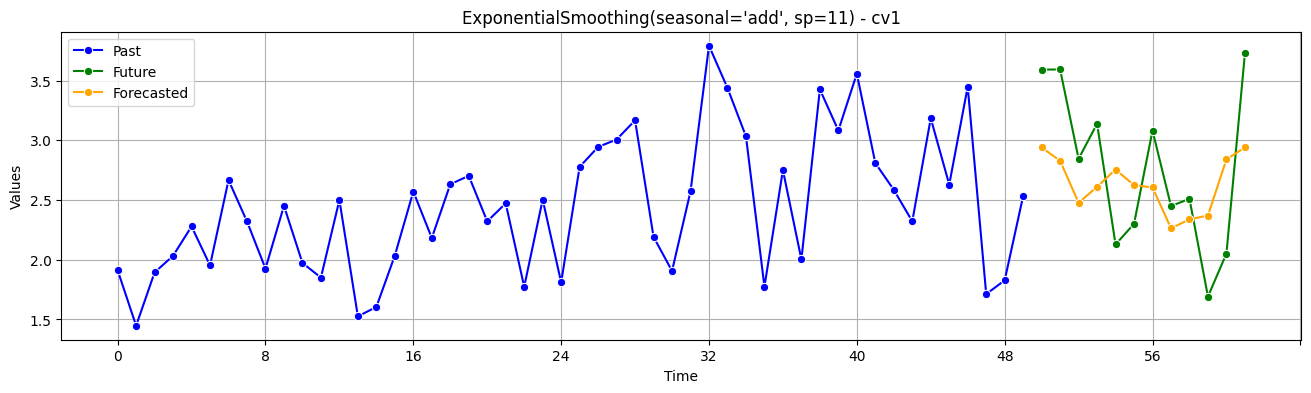

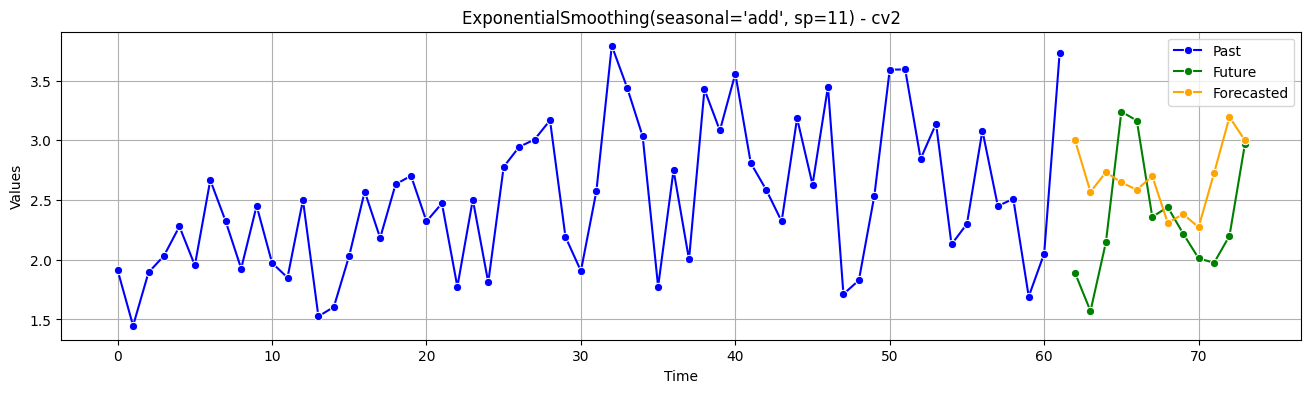

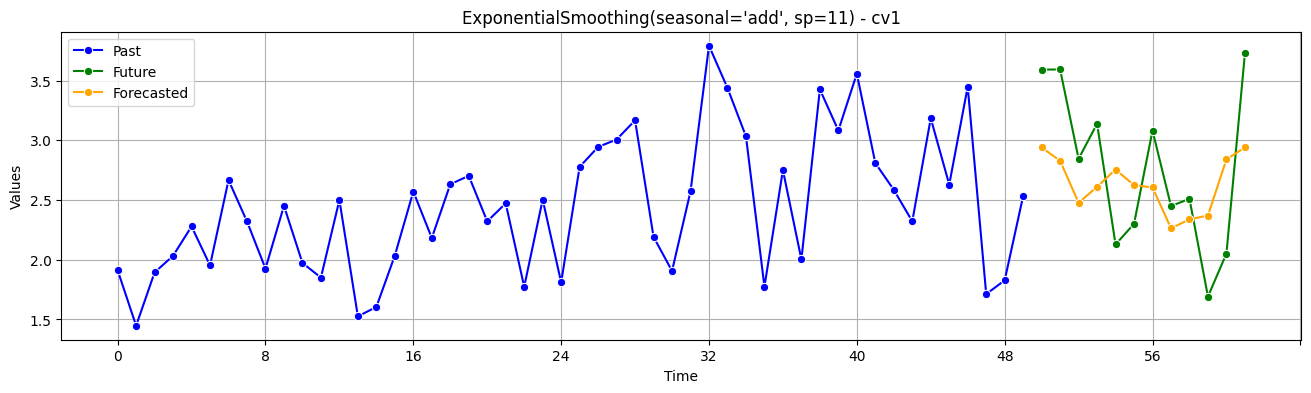

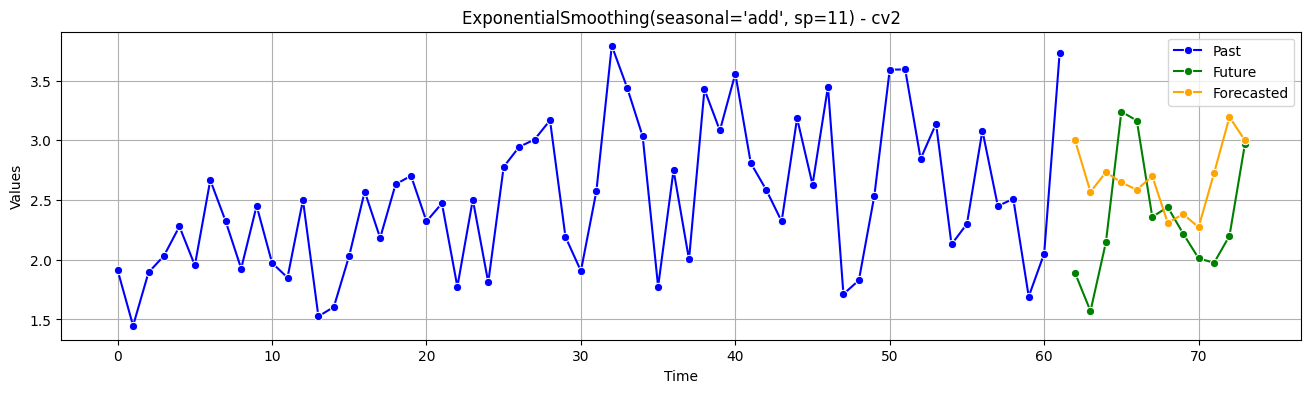

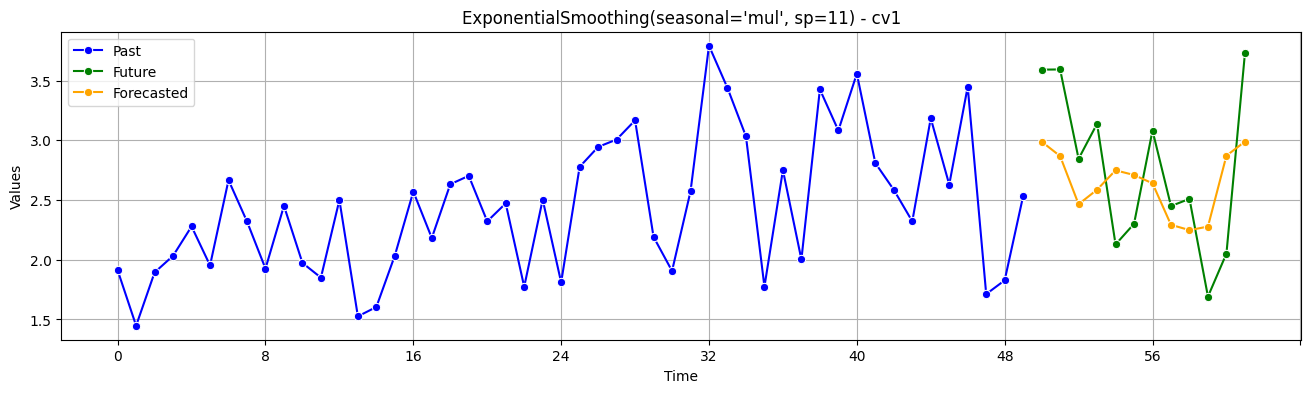

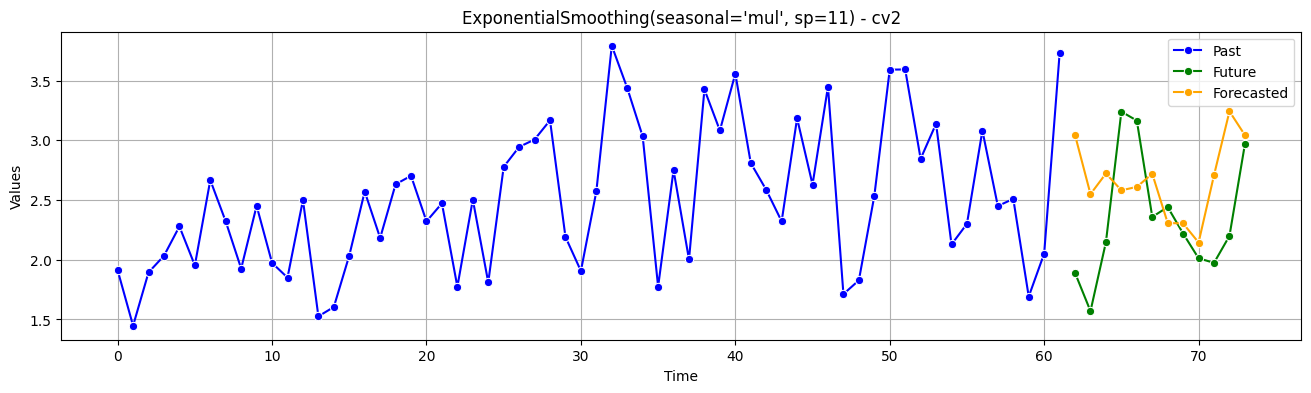

In [20]:
for iteration in best_perf.head(3).itertuples():
    params = iteration.params
    model = Model(model=ExponentialSmoothing, **params)
    for cv in ["cv1", "cv2"]:
        plot(data_model=data_model, model=model, cv=cv, title=str(model.model))

## Best stable performance

In [21]:
hw_hpt_summary["params"] = hw_hpt_summary["params"].astype(str)
best_stable = hw_hpt_summary.groupby(["name", "top_trial", "params"], as_index=False)[["mape", "mae", "rmse"]].mean().sort_values("rmse")
best_stable["params"] = best_stable["params"].apply(eval)
best_stable

name  top_trial  \
2  ExponentialSmoothing(seasonal='mul', sp=11)          1   
3  ExponentialSmoothing(seasonal='mul', sp=11)          2   
4  ExponentialSmoothing(seasonal='mul', sp=11)          3   
0  ExponentialSmoothing(seasonal='add', sp=11)          4   
1  ExponentialSmoothing(seasonal='add', sp=11)          5   

                                         params      mape       mae      rmse  
2  {'trend': None, 'seasonal': 'mul', 'sp': 11}  0.227834  0.532388  0.607124  
3  {'trend': None, 'seasonal': 'mul', 'sp': 11}  0.227834  0.532388  0.607124  
4  {'trend': None, 'seasonal': 'mul', 'sp': 11}  0.227834  0.532388  0.607124  
0  {'trend': None, 'seasonal': 'add', 'sp': 11}  0.230358  0.536948  0.609464  
1  {'trend': None, 'seasonal': 'add', 'sp': 11}  0.230358  0.536948  0.609464

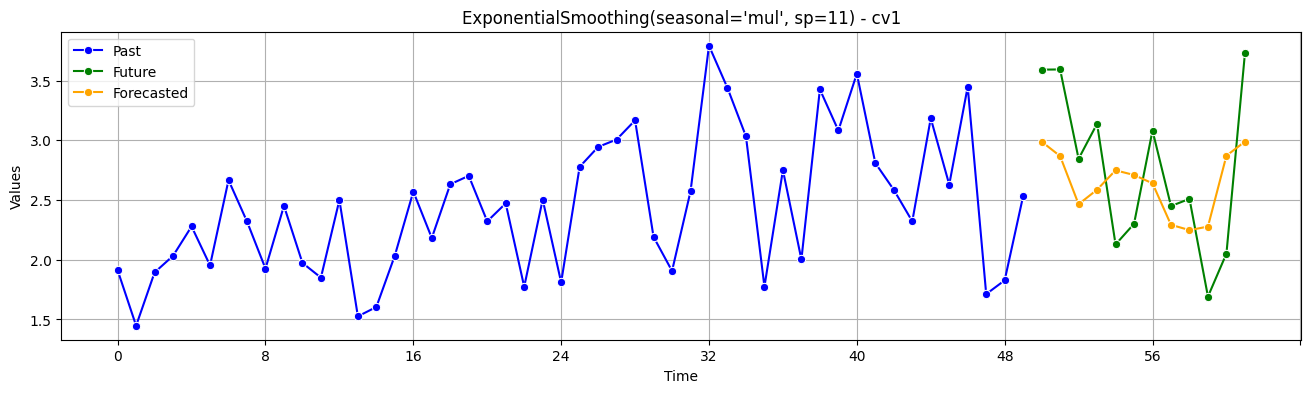

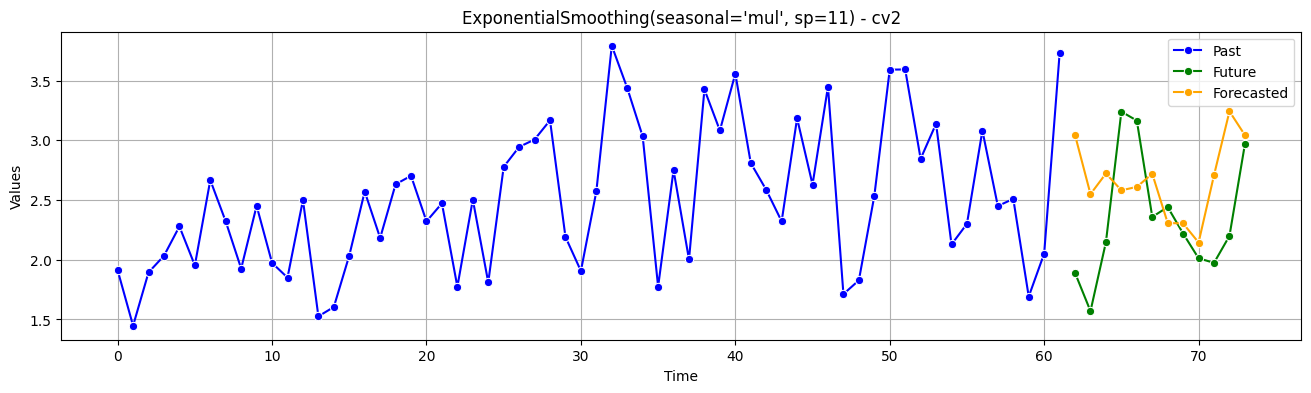

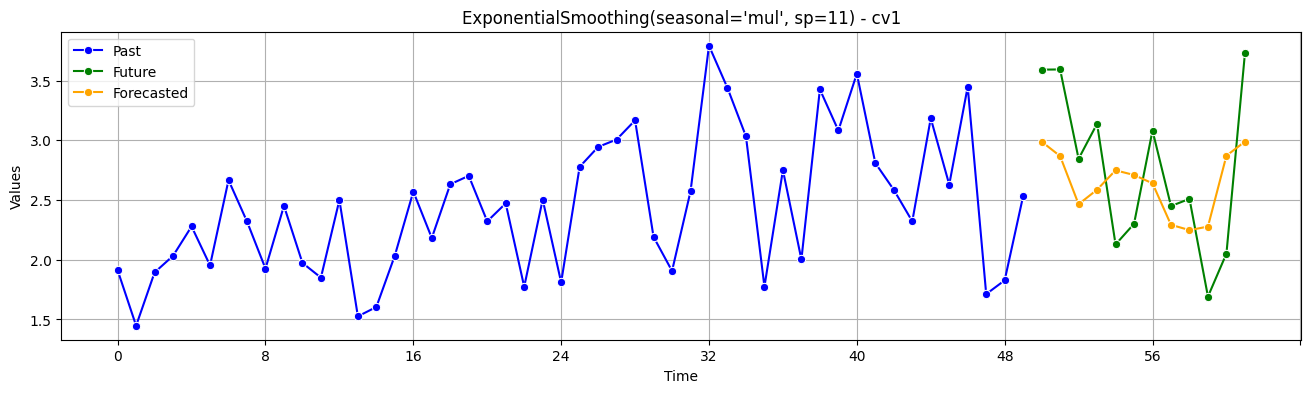

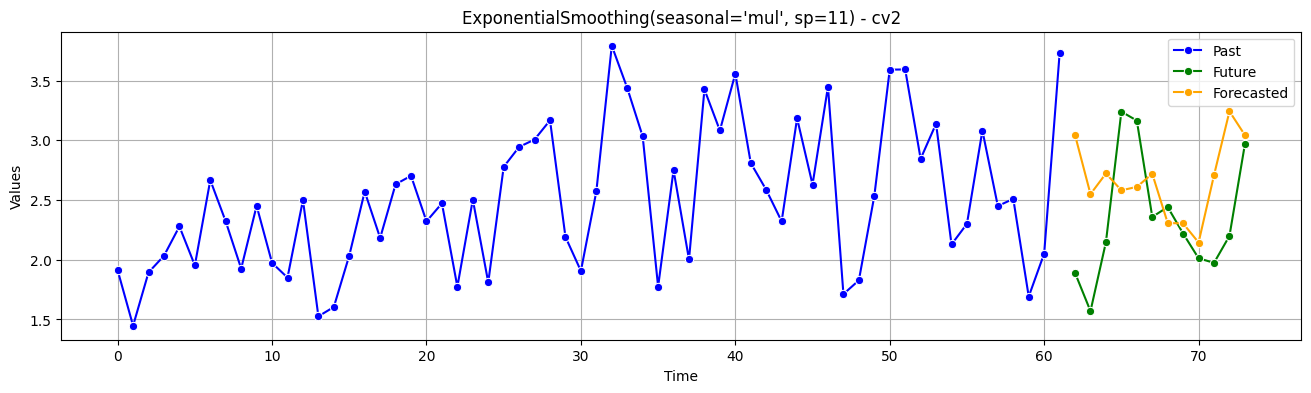

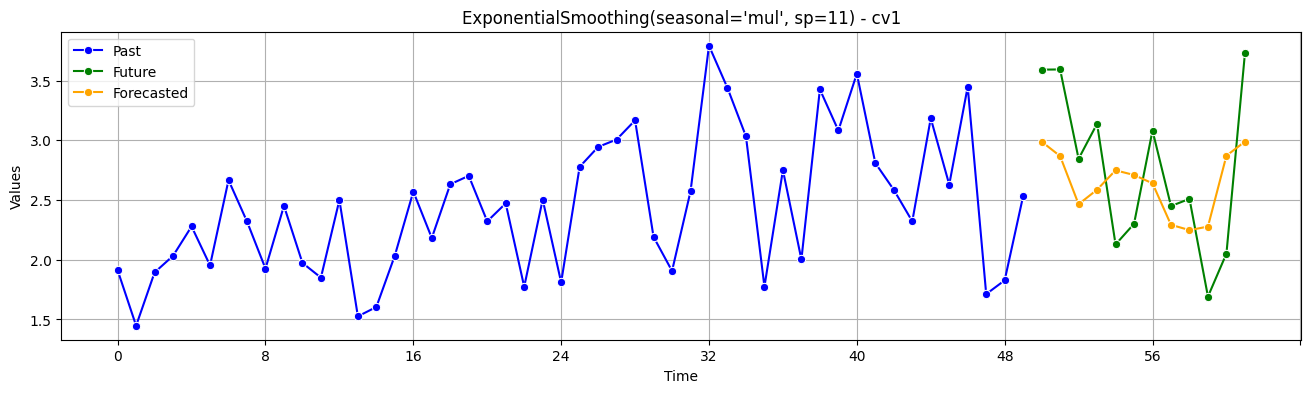

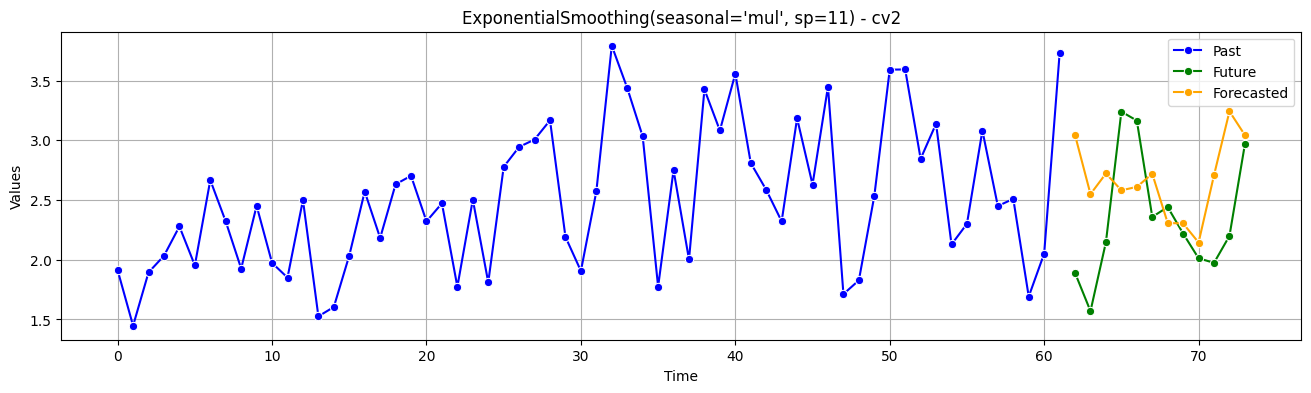

In [22]:
for iteration in best_stable.head(3).itertuples():
    params = iteration.params
    model = Model(model=ExponentialSmoothing, **params)
    for cv in ["cv1", "cv2"]:
        plot(data_model=data_model, model=model, cv=cv, title=str(model.model))

ExponentialSmoothing(seasonal='add', sp=11) is the best model on CV2 and the stablest one.

# Machine Learning Approach

## Random Forest

In [23]:
ttt = data_model.ttt_split()
def rf_optimizer(trial) -> float:
    """
    Optimizes Random Forest model hyperparameters using cross-validation and returns the RMSE.

    Parameters
    ----------
    trial : optuna.trial.Trial
        An Optuna trial object used for suggesting hyperparameters.

    Returns
    -------
    float
        The RMSE of the forecast on the validation set.

    Notes
    -----
    This function is designed to be used with Optuna for hyperparameter optimization.
    It tunes the n_estimators and max_depth parameters of the Random Forest model.
    """
    # Hyperparameters to tune
    n_estimators = trial.suggest_int("n_estimators", 10, 500)
    max_depth = trial.suggest_int("max_depth", 1, 10)

    # Model setup
    model = Model(
        model=RandomForestRegressor, is_sklearn=True, 
        n_estimators=n_estimators, max_depth=max_depth
        )
    cv1 = ttt["cv1"]
    fcast = model.forecast(cv1[0])

    # Metrics
    summary = data_model.get_metrics(forecast=fcast, true=cv1[-1])

    return summary["rmse"]

study = optuna.create_study(direction="minimize")
study.optimize(rf_optimizer, n_trials=n_trials, n_jobs=-1)

In [24]:
top5_trials = sorted(study.get_trials(), key=lambda ele: ele.values[0])[:5]
dfs = []
for idx, trial in enumerate(top5_trials, start=1):
    params = trial.params
    model = Model(
        model=RandomForestRegressor, is_sklearn=True, **params
        )
    summary = cv_summary(data_model=data_model, model=model)
    summary["top_trial"] = idx
    summary["params"] = [params] * 2
    dfs.append(summary)

rf_hpt_summary = pd.concat(dfs)
rf_hpt_summary

name   cv      mape       mae  \
0  TransformedTargetForecaster(steps=[('model',\n...  cv1  0.192239  0.555479   
1  TransformedTargetForecaster(steps=[('model',\n...  cv2  0.289304  0.599534   
0  TransformedTargetForecaster(steps=[('model',\n...  cv1  0.186836  0.525435   
1  TransformedTargetForecaster(steps=[('model',\n...  cv2  0.290955  0.608575   
0  TransformedTargetForecaster(steps=[('model',\n...  cv1  0.193735  0.559847   
1  TransformedTargetForecaster(steps=[('model',\n...  cv2  0.304478  0.635297   
0  TransformedTargetForecaster(steps=[('model',\n...  cv1  0.170202  0.495223   
1  TransformedTargetForecaster(steps=[('model',\n...  cv2  0.276025  0.570289   
0  TransformedTargetForecaster(steps=[('model',\n...  cv1  0.187641  0.533529   
1  TransformedTargetForecaster(steps=[('model',\n...  cv2  0.288437  0.602980   

       rmse  top_trial                                 params  
0  0.691003          1   {'n_estimators': 36, 'max_depth': 4}  
1  0.712330          1   {'n_estimators': 36, 'max_depth': 4}  
0  0.666465          2   {'n_estimators': 70, 'max_depth': 5}  
1  0.713879          2   {'n_estimators': 70, 'max_depth': 5}  
0  0.702099          3  {'n_estimators': 137, 'max_depth': 4}  
1  0.747674          3  {'n_estimators': 137, 'max_depth': 4}  
0  0.642380          4   {'n_estimators': 44, 'max_depth': 4}  
1  0.697525          4   {'n_estimators': 44, 'max_depth': 4}  
0  0.672344          5  {'n_estimators': 137, 'max_depth': 4}  
1  0.706358          5  {'n_estimators': 137, 'max_depth': 4}

### Best performance on CV2

name   cv      mape       mae  \
1  TransformedTargetForecaster(steps=[('model',\n...  cv2  0.276025  0.570289   
1  TransformedTargetForecaster(steps=[('model',\n...  cv2  0.288437  0.602980   
1  TransformedTargetForecaster(steps=[('model',\n...  cv2  0.289304  0.599534   
1  TransformedTargetForecaster(steps=[('model',\n...  cv2  0.290955  0.608575   
1  TransformedTargetForecaster(steps=[('model',\n...  cv2  0.304478  0.635297   

       rmse  top_trial                                 params  
1  0.697525          4   {'n_estimators': 44, 'max_depth': 4}  
1  0.706358          5  {'n_estimators': 137, 'max_depth': 4}  
1  0.712330          1   {'n_estimators': 36, 'max_depth': 4}  
1  0.713879          2   {'n_estimators': 70, 'max_depth': 5}  
1  0.747674          3  {'n_estimators': 137, 'max_depth': 4}

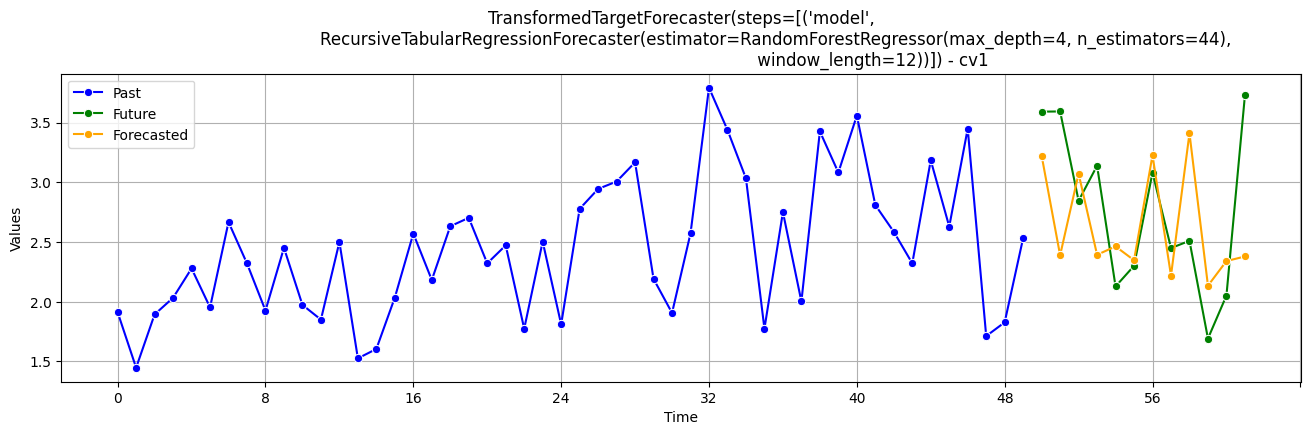

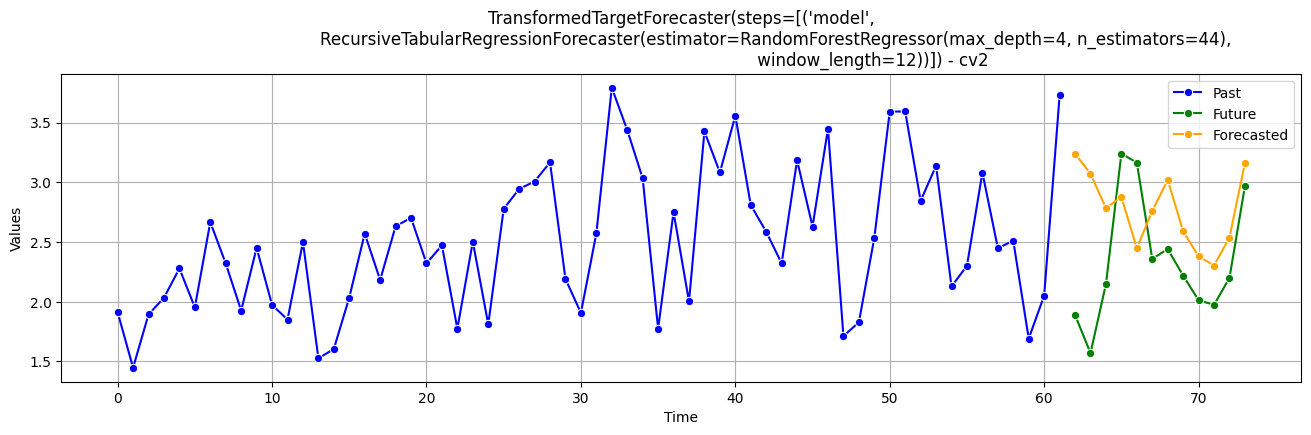

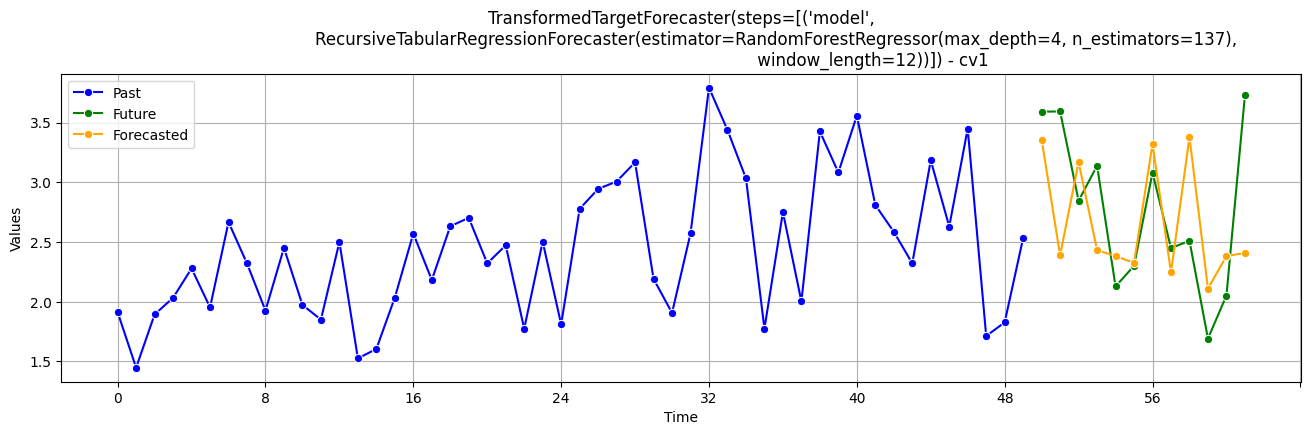

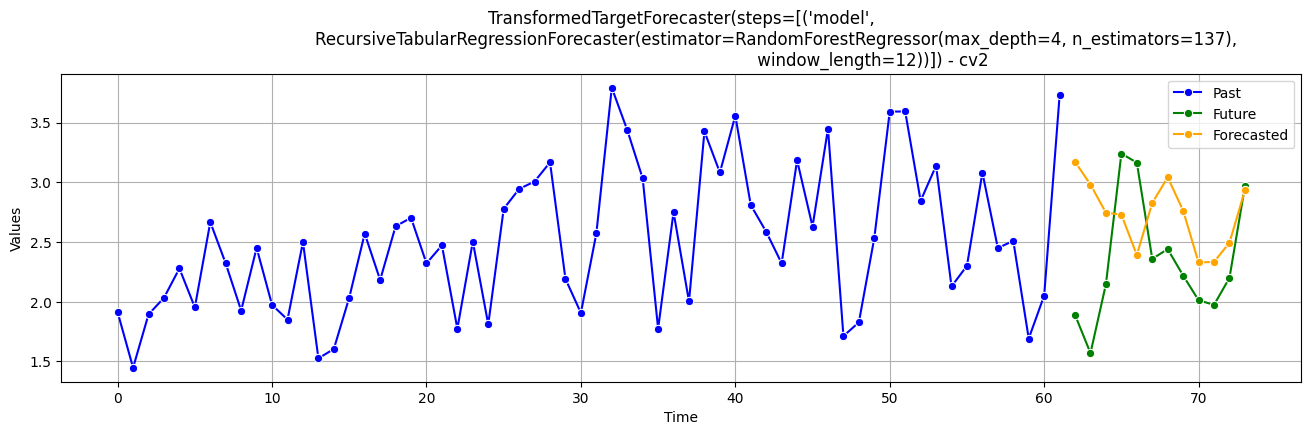

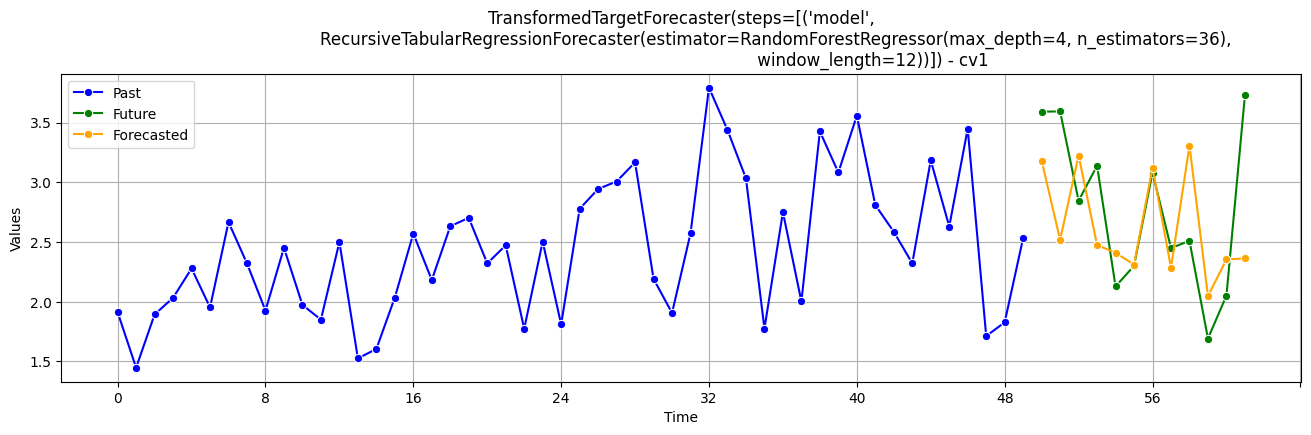

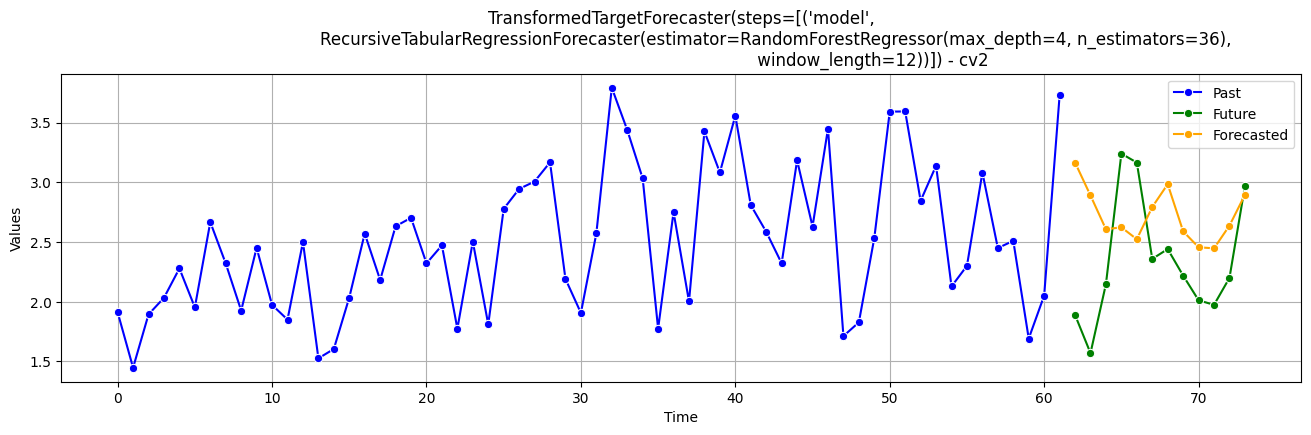

In [25]:
best_perf = rf_hpt_summary[rf_hpt_summary["cv"] == "cv2"].sort_values("rmse")
display(best_perf)

for iteration in best_perf.head(3).itertuples():
    params = iteration.params
    model = Model(
        model=RandomForestRegressor, is_sklearn=True, **params
        )
    for cv in ["cv1", "cv2"]:
        plot(data_model=data_model, model=model, cv=cv, title=str(model.model))

### Best stable performance

name  top_trial  \
3  TransformedTargetForecaster(steps=[('model',\n...          4   
1  TransformedTargetForecaster(steps=[('model',\n...          5   
4  TransformedTargetForecaster(steps=[('model',\n...          2   
2  TransformedTargetForecaster(steps=[('model',\n...          1   
0  TransformedTargetForecaster(steps=[('model',\n...          3   

                                  params      mape       mae      rmse  
3   {'n_estimators': 44, 'max_depth': 4}  0.223113  0.532756  0.669952  
1  {'n_estimators': 137, 'max_depth': 4}  0.238039  0.568255  0.689351  
4   {'n_estimators': 70, 'max_depth': 5}  0.238895  0.567005  0.690172  
2   {'n_estimators': 36, 'max_depth': 4}  0.240772  0.577506  0.701667  
0  {'n_estimators': 137, 'max_depth': 4}  0.249107  0.597572  0.724887

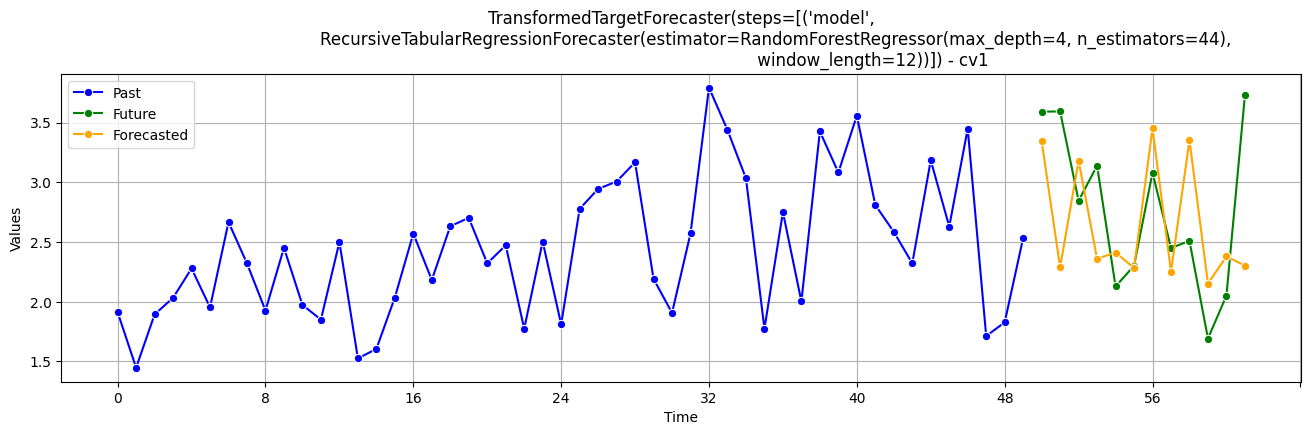

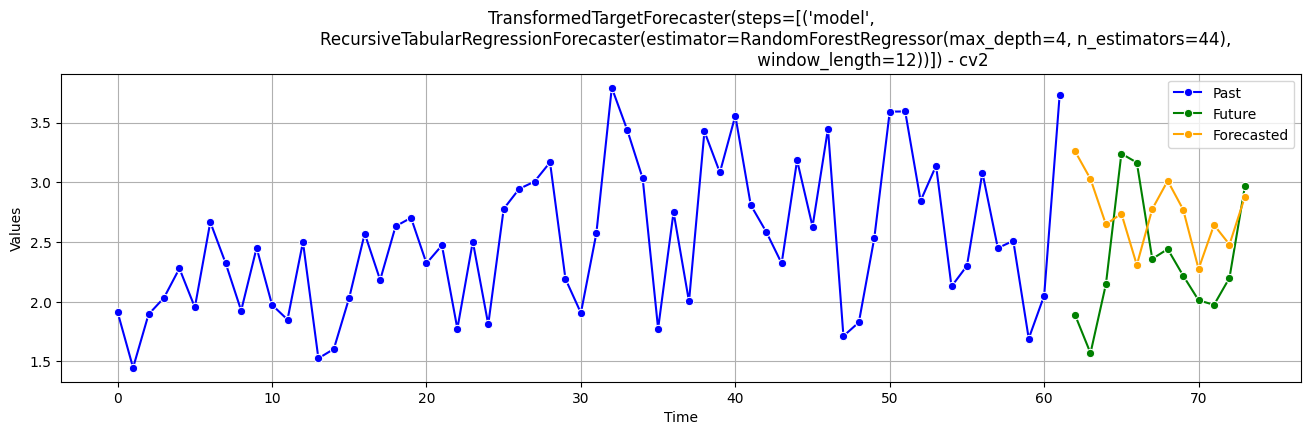

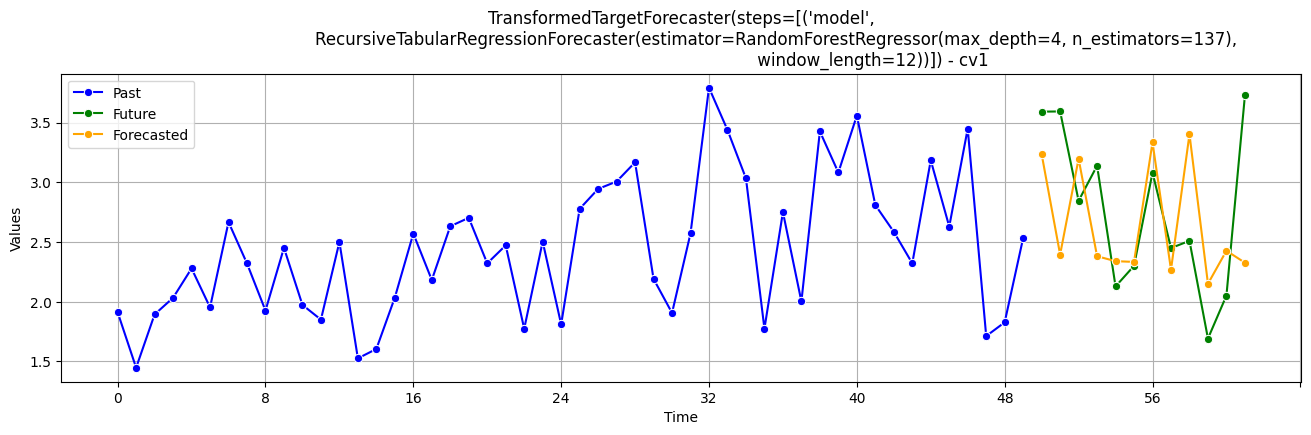

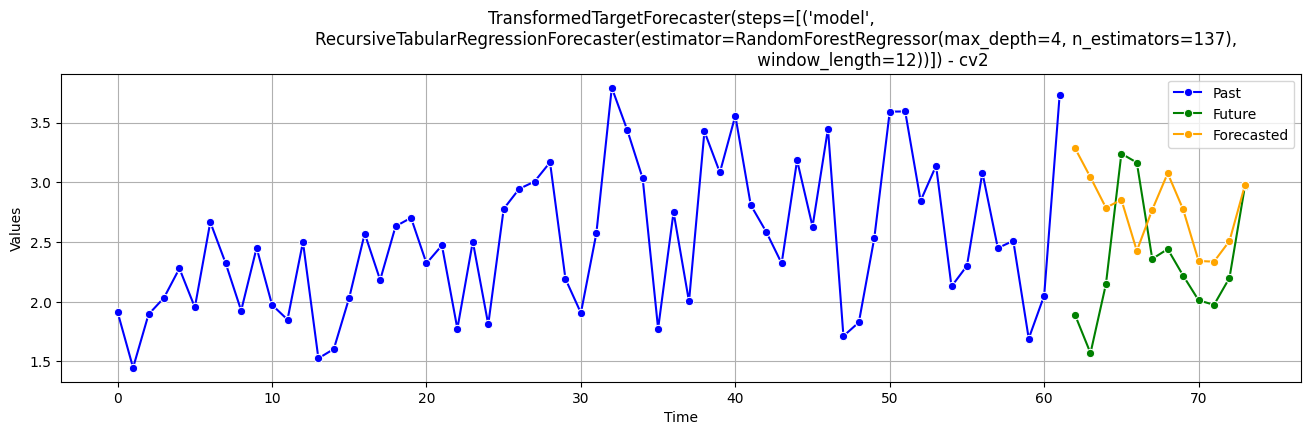

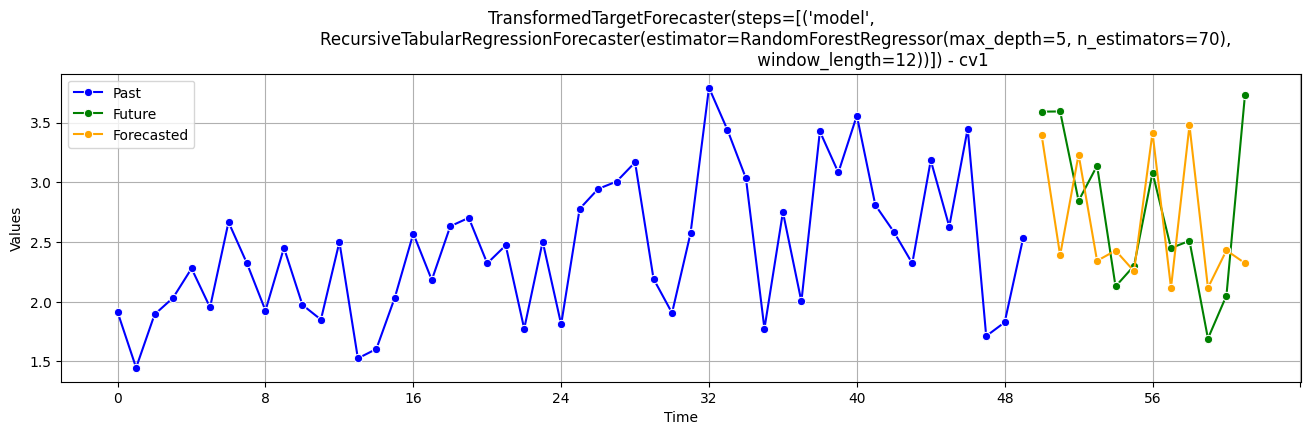

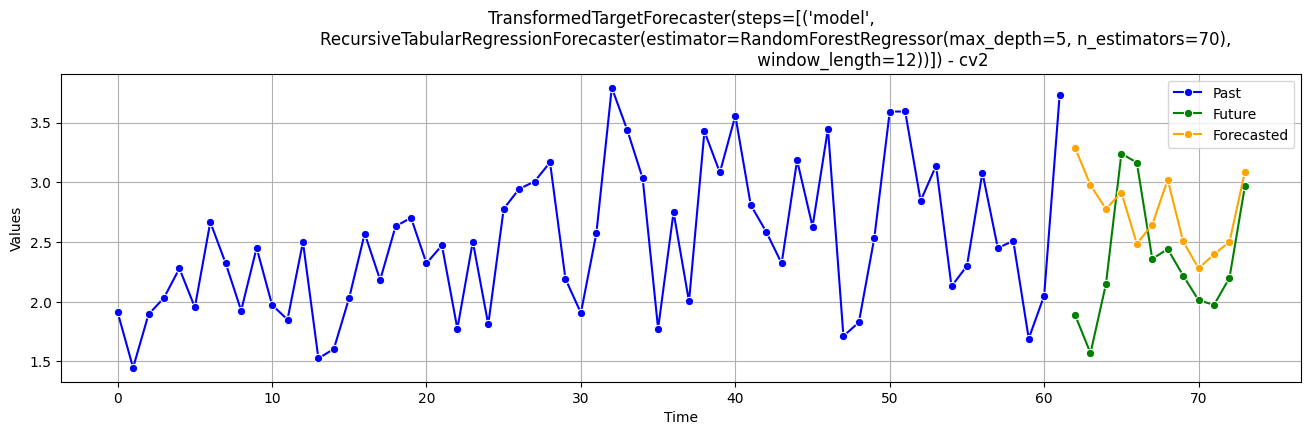

In [26]:
rf_hpt_summary["params"] = rf_hpt_summary["params"].astype(str)
best_stable = rf_hpt_summary.groupby(["name", "top_trial", "params"], as_index=False)[["mape", "mae", "rmse"]].mean().sort_values("rmse")
best_stable["params"] = best_stable["params"].apply(eval)
display(best_stable)

for iteration in best_stable.head(3).itertuples():
    params = iteration.params
    model = Model(
        model=RandomForestRegressor, is_sklearn=True, **params
        )
    for cv in ["cv1", "cv2"]:
        plot(data_model=data_model, model=model, cv=cv, title=str(model.model))

RandomForest(n_estimator=44, max_depth=4) is the best RF model.

## Elastic Net

In [27]:
ttt = data_model.ttt_split()
def elastic_optimizer(trial) -> float:
    """
    Optimizes ElasticNet model hyperparameters using cross-validation and returns the RMSE.

    Parameters
    ----------
    trial : optuna.trial.Trial
        An Optuna trial object used for suggesting hyperparameters.

    Returns
    -------
    float
        The RMSE of the forecast on the validation set.

    Notes
    -----
    This function is designed to be used with Optuna for hyperparameter optimization.
    It tunes the alpha and l1_ratio parameters of the ElasticNet model.
    """
    # Hyperparameters to tune
    alpha = trial.suggest_float("alpha", .001, 1, log=True)
    l1_ratio = trial.suggest_float("l1_ratio", .001, 1, log=True)

    # Model setup
    model = Model(
        model=ElasticNet, is_sklearn=True, 
        alpha=alpha, l1_ratio=l1_ratio
        )
    cv1 = ttt["cv1"]
    fcast = model.forecast(cv1[0])

    # Metrics
    summary = data_model.get_metrics(forecast=fcast, true=cv1[-1])

    return summary["rmse"]

study = optuna.create_study(direction="minimize")
study.optimize(elastic_optimizer, n_trials=n_trials, n_jobs=-1)

In [28]:
top5_trials = sorted(study.get_trials(), key=lambda ele: ele.values[0])[:5]
dfs = []
for idx, trial in enumerate(top5_trials, start=1):
    params = trial.params
    model = Model(
        model=ElasticNet, is_sklearn=True, **params
        )
    summary = cv_summary(data_model=data_model, model=model)
    summary["top_trial"] = idx
    summary["params"] = [params] * 2
    dfs.append(summary)

elastic_hpt_summary = pd.concat(dfs)
elastic_hpt_summary

name   cv      mape       mae  \
0  TransformedTargetForecaster(steps=[('model',\n...  cv1  0.182088  0.488129   
1  TransformedTargetForecaster(steps=[('model',\n...  cv2  0.334471  0.705512   
0  TransformedTargetForecaster(steps=[('model',\n...  cv1  0.182206  0.488685   
1  TransformedTargetForecaster(steps=[('model',\n...  cv2  0.332117  0.700298   
0  TransformedTargetForecaster(steps=[('model',\n...  cv1  0.182234  0.488822   
1  TransformedTargetForecaster(steps=[('model',\n...  cv2  0.331497  0.698925   
0  TransformedTargetForecaster(steps=[('model',\n...  cv1  0.182152  0.488370   
1  TransformedTargetForecaster(steps=[('model',\n...  cv2  0.334589  0.705764   
0  TransformedTargetForecaster(steps=[('model',\n...  cv1  0.182096  0.488115   
1  TransformedTargetForecaster(steps=[('model',\n...  cv2  0.335582  0.707964   

       rmse  top_trial                                             params  
0  0.570299          1  {'alpha': 0.10169855593584375, 'l1_ratio': 0.0...  
1  0.844837          1  {'alpha': 0.10169855593584375, 'l1_ratio': 0.0...  
0  0.570302          2  {'alpha': 0.1109594040707736, 'l1_ratio': 0.00...  
1  0.837888          2  {'alpha': 0.1109594040707736, 'l1_ratio': 0.00...  
0  0.570313          3  {'alpha': 0.11353033167306245, 'l1_ratio': 0.0...  
1  0.836061          3  {'alpha': 0.11353033167306245, 'l1_ratio': 0.0...  
0  0.570334          4  {'alpha': 0.09833928809969046, 'l1_ratio': 0.0...  
1  0.845251          4  {'alpha': 0.09833928809969046, 'l1_ratio': 0.0...  
0  0.570343          5  {'alpha': 0.09478553142383356, 'l1_ratio': 0.0...  
1  0.848185          5  {'alpha': 0.09478553142383356, 'l1_ratio': 0.0...

### Best performance on CV2

name   cv      mape       mae  \
1  TransformedTargetForecaster(steps=[('model',\n...  cv2  0.331497  0.698925   
1  TransformedTargetForecaster(steps=[('model',\n...  cv2  0.332117  0.700298   
1  TransformedTargetForecaster(steps=[('model',\n...  cv2  0.334471  0.705512   
1  TransformedTargetForecaster(steps=[('model',\n...  cv2  0.334589  0.705764   
1  TransformedTargetForecaster(steps=[('model',\n...  cv2  0.335582  0.707964   

       rmse  top_trial                                             params  
1  0.836061          3  {'alpha': 0.11353033167306245, 'l1_ratio': 0.0...  
1  0.837888          2  {'alpha': 0.1109594040707736, 'l1_ratio': 0.00...  
1  0.844837          1  {'alpha': 0.10169855593584375, 'l1_ratio': 0.0...  
1  0.845251          4  {'alpha': 0.09833928809969046, 'l1_ratio': 0.0...  
1  0.848185          5  {'alpha': 0.09478553142383356, 'l1_ratio': 0.0...

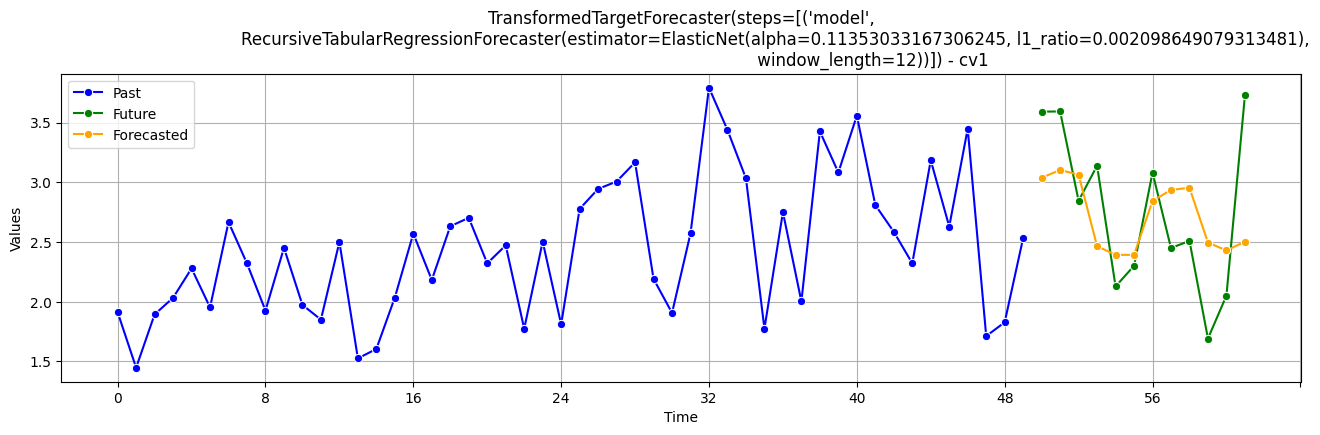

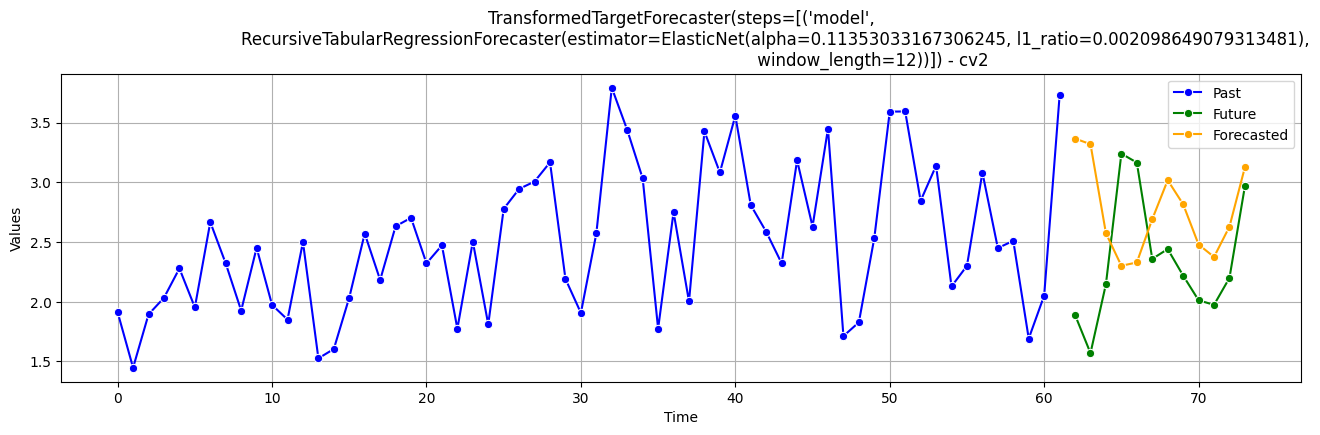

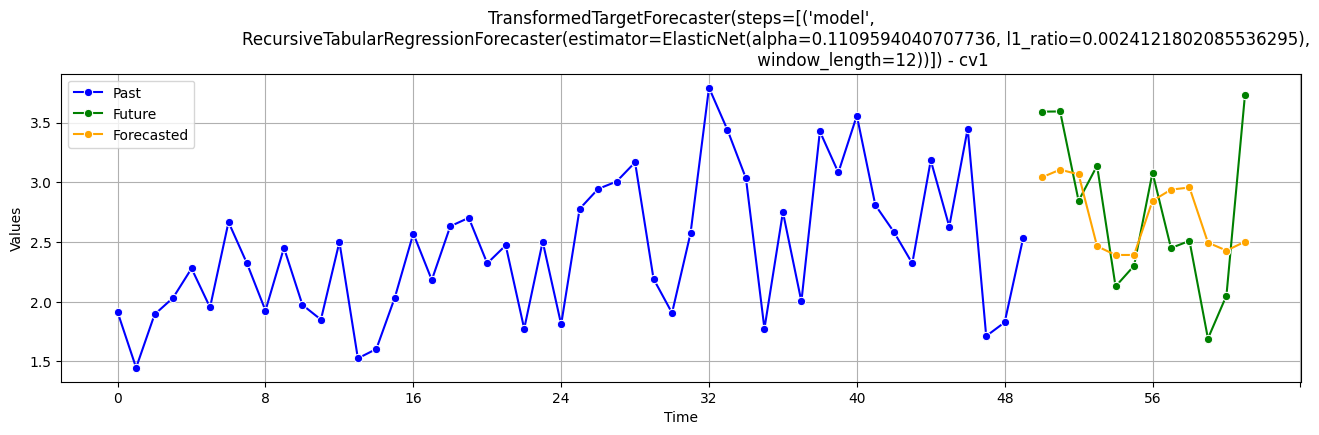

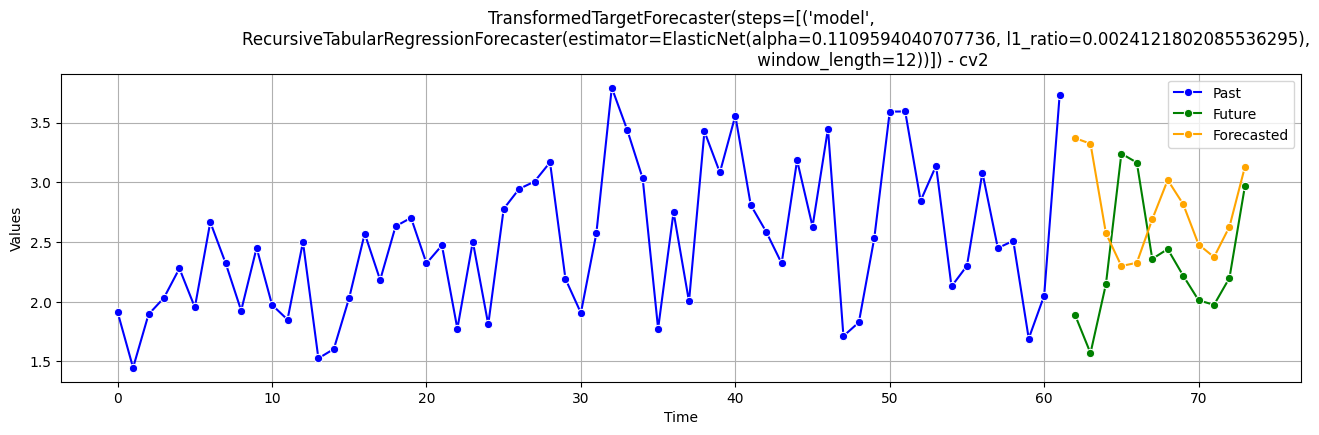

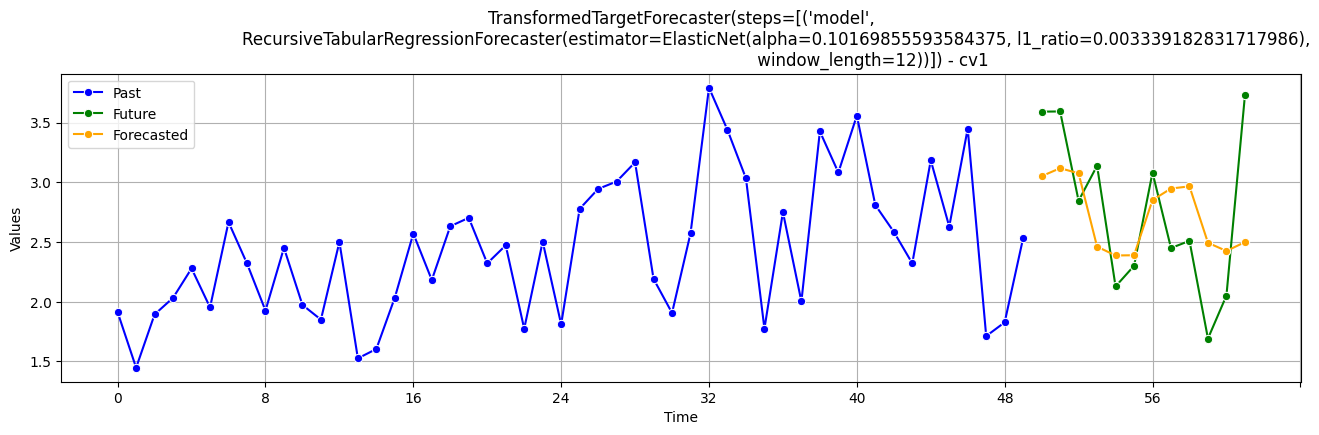

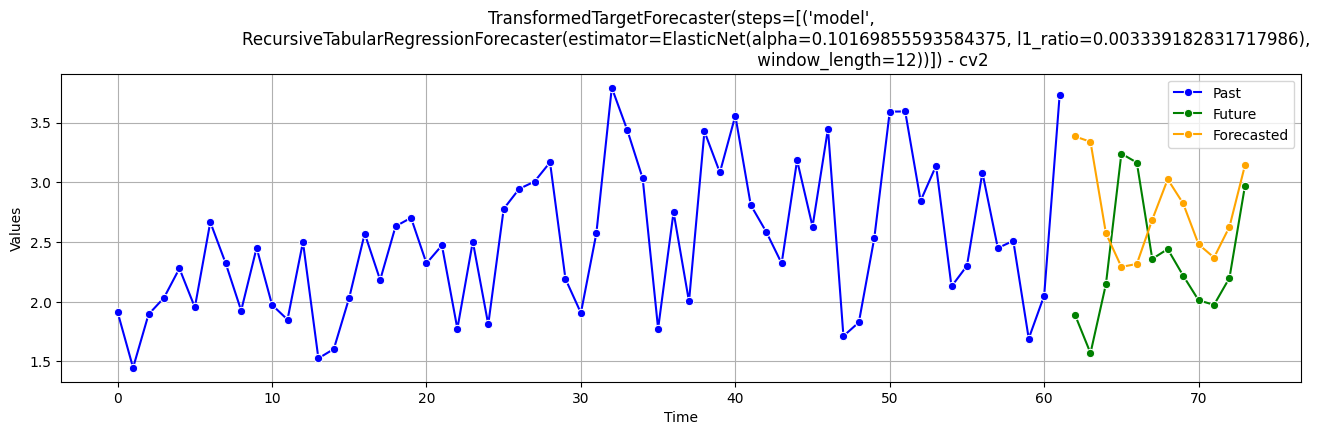

In [29]:
best_perf = elastic_hpt_summary[elastic_hpt_summary["cv"] == "cv2"].sort_values("rmse")
display(best_perf)

for iteration in best_perf.head(3).itertuples():
    params = iteration.params
    model = Model(
        model=ElasticNet, is_sklearn=True, **params
        )
    for cv in ["cv1", "cv2"]:
        plot(data_model=data_model, model=model, cv=cv, title=str(model.model))

### Best stable performance

name  top_trial  \
4  TransformedTargetForecaster(steps=[('model',\n...          3   
3  TransformedTargetForecaster(steps=[('model',\n...          2   
2  TransformedTargetForecaster(steps=[('model',\n...          1   
1  TransformedTargetForecaster(steps=[('model',\n...          4   
0  TransformedTargetForecaster(steps=[('model',\n...          5   

                                              params      mape       mae  \
4  {'alpha': 0.11353033167306245, 'l1_ratio': 0.0...  0.256865  0.593873   
3  {'alpha': 0.1109594040707736, 'l1_ratio': 0.00...  0.257161  0.594491   
2  {'alpha': 0.10169855593584375, 'l1_ratio': 0.0...  0.258279  0.596820   
1  {'alpha': 0.09833928809969046, 'l1_ratio': 0.0...  0.258370  0.597067   
0  {'alpha': 0.09478553142383356, 'l1_ratio': 0.0...  0.258839  0.598039   

       rmse  
4  0.703187  
3  0.704095  
2  0.707568  
1  0.707792  
0  0.709264

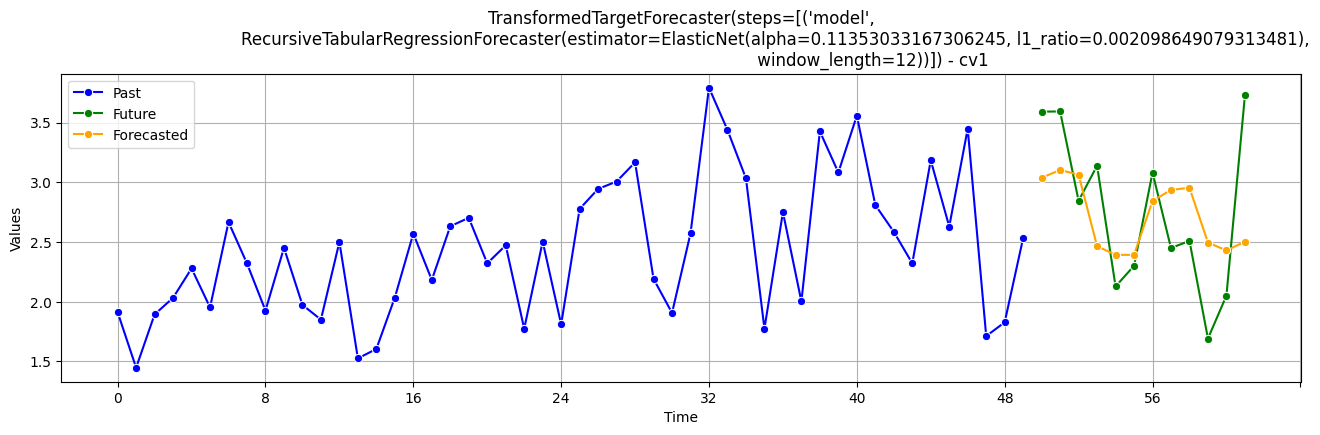

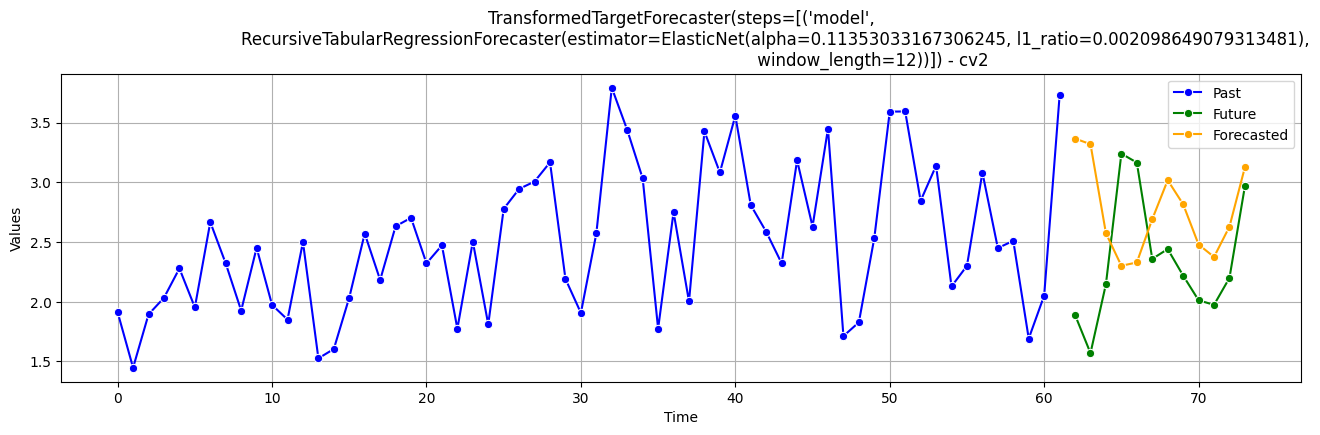

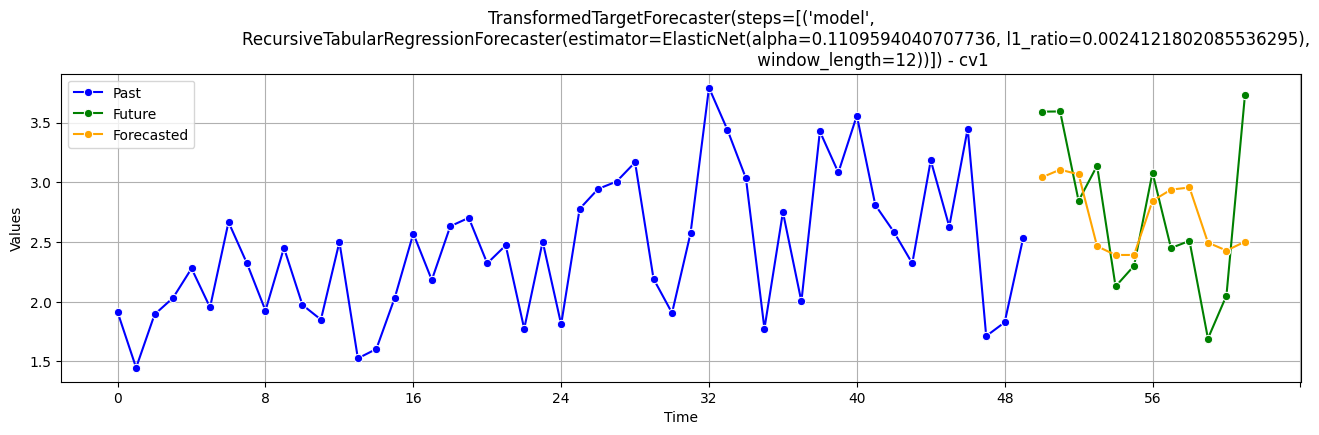

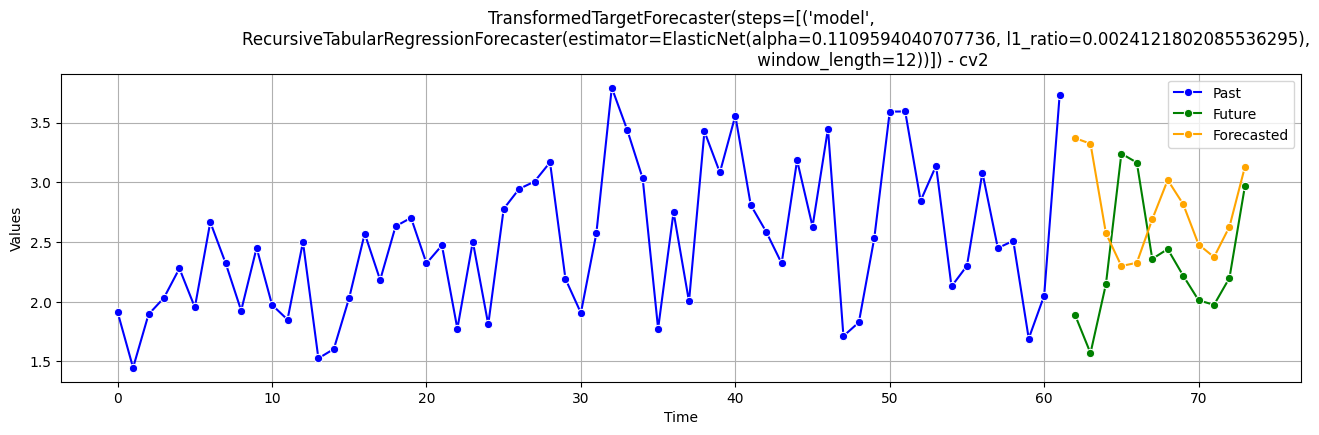

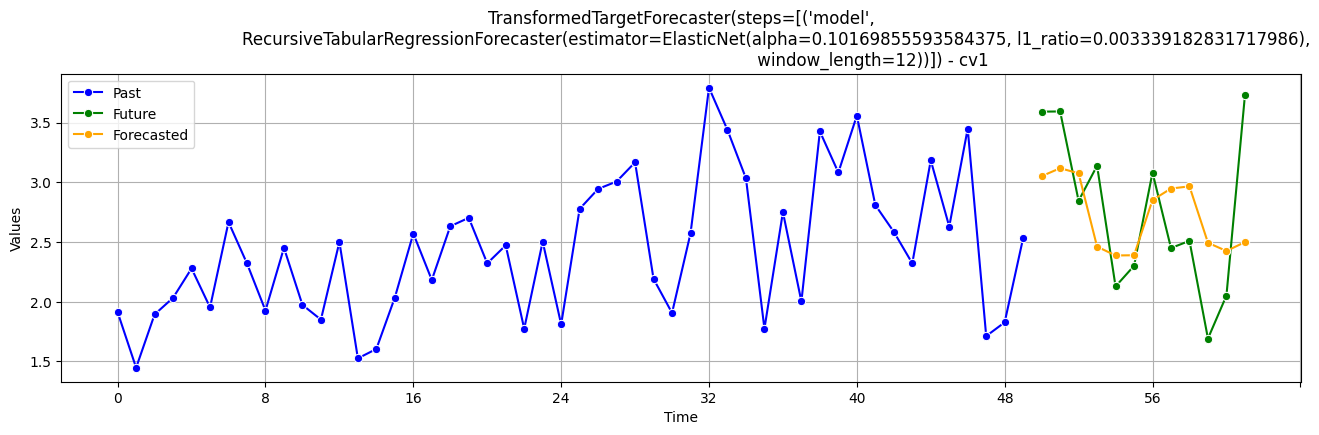

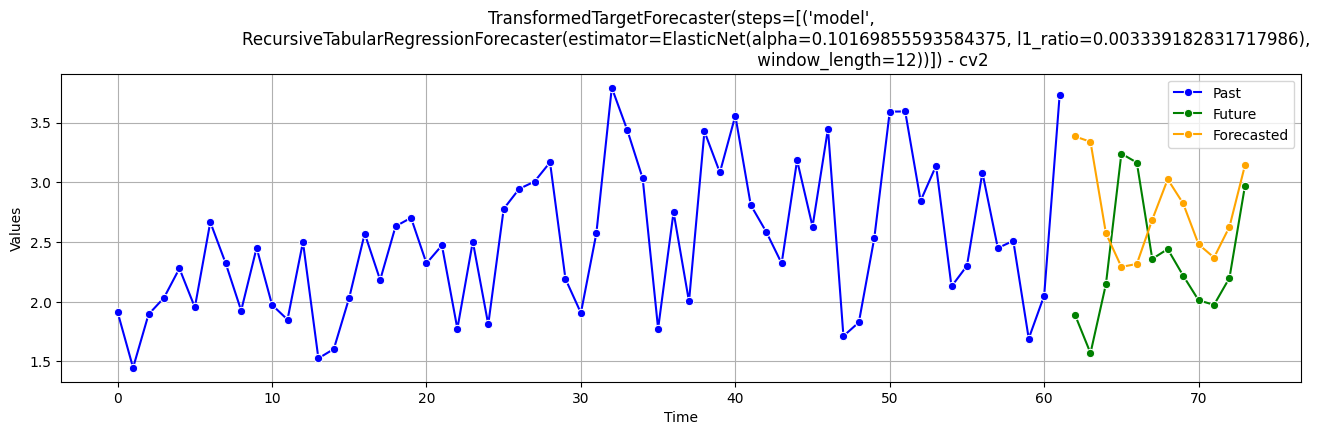

In [30]:
elastic_hpt_summary["params"] = elastic_hpt_summary["params"].astype(str)
best_stable = elastic_hpt_summary.groupby(["name", "top_trial", "params"], as_index=False)[["mape", "mae", "rmse"]].mean().sort_values("rmse")
best_stable["params"] = best_stable["params"].apply(eval)
display(best_stable)

for iteration in best_stable.head(3).itertuples():
    params = iteration.params
    model = Model(
        model=ElasticNet, is_sklearn=True, **params
        )
    for cv in ["cv1", "cv2"]:
        plot(data_model=data_model, model=model, cv=cv, title=str(model.model))

In [31]:
best_perf.head(1).params.values

array([{'alpha': 0.11353033167306245, 'l1_ratio': 0.002098649079313481}],
      dtype=object)

ElasticNet('alpha'=0.11353033167306245, 'l1_ratio'=0.002098649079313481) is the best model.

# Summary

- ElasticNet: mape=0.256865, mae=0.593873, rmse=0.703187
- RF: mape=0.223113, mae=0.532756, rmse=0.669952
- HW: mape=0.230358, mae=0.536948, rmse=0.609464
- ARIMA: mape=0.232036, mae=0.542176, rmse=0.637554

Holt Winters model is one one selected for this TS because of looking into the trials is the one best performance gives us in an stable approach.

Random forest has a lower MAPE but a higher RMSE this is because when the RF fails the failure is bigger than HW for example.